In [1]:
from utils import *
import os
import pandas as pd
import numpy as np 
from scipy.stats import entropy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

import rasterio
import geopandas as gpd
from pyproj import CRS, Transformer
from geopy.distance import geodesic
from shapely.geometry import Point

%matplotlib inline

# The analyses below are done using the files in the Analyses_2024-10-09 directory. Note that you only need to complete steps 1 and 2 one time and can then load the results for subsequent figure generation.

# 1. Create additional dataframes with dispersal velocities that include SC1/SC2 traveling to the closest point to in its respective province of emergence

In [ ]:
def extract_sc_tip(df, sc):
    """
    Extract the row for the SC tip from the allBranches file.
    """
    # Determine the tip label based on SC type
    if sc == 1:
        tip_label = 'SC1_AY394995.1'
    else:
        tip_label = 'SC2_MN908947.3'

    # Return the DataFrame containing the row for the SC tip
    return df[df['tipLabel'] == tip_label]


def extract_sc_ghost_mrca(df, sc, ghosts=['Ghost1', 'Ghost2']):
    """
    Get the MRCA of the ghosts and the SC.

    Parameters:
    - df (pd.DataFrame): DataFrame containing dispersal velocity information.
    - sc: 1 or 2
    - ghosts (list): List of ghost tip labels.

    Returns:
    - keyNodes (pd.DataFrame): DataFrame containing the MRCA of the ghosts and the SC.
    """
    # Map SC number to the corresponding tip label
    if sc == 1:
        sc = 'SC1_AY394995.1'
    else:
        sc = 'SC2_MN908947.3'

    # Find rows with tipLabels in ['Ghost1', 'Ghost2', 'SC2_MN908947.3'] or ['Ghost1', 'Ghost2', 'SC1_AY394995.1']
    keyNodes = df[df['tipLabel'].isin(ghosts + [sc])].copy()

    # Get the node with the oldest startYear (i.e., the oldest parent, the MRCA of the ghosts and the SC)
    node = keyNodes[keyNodes['startYear'] == keyNodes['startYear'].min()]['node1'].item()

    # Extract the row for the MRCA and set a custom tipLabel
    mrca_row = df[df['node2'] == node].copy()
    mrca_row['tipLabel'] = 'sc_ghost_mrca'

    return mrca_row


def extract_ghost_tips(df, ghosts=['Ghost1', 'Ghost2']):
    """
    Extract the row for the SC tip from the allBranches file.
    """
    # Return rows where tipLabel is either 'Ghost1' or 'Ghost2'
    return df[df['tipLabel'].isin(ghosts)]


def get_distances_sc(df, 
                     sc, 
                     background_path='./All_Natural_Earth_files/Gray_background.tif',
                     provinces_path='./All_Chinese_shapefiles/Admin-2_polygons.shp'):
    """
    Get distances and update DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing time, latitude, and longitude information.
    - sc (int): Is this SC1 or SC2?
    """
    # Read the background raster
    background = rasterio.open(background_path)

    # Read the shapefile
    provinces = gpd.read_file(provinces_path)

    # Define the CRS of the background raster
    background_crs = CRS.from_string(background.crs.to_string())

    # Define the target CRS for transformation
    target_crs = background_crs

    # Perform the transformation
    transformer = Transformer.from_crs(provinces.crs, target_crs, always_xy=True)
    provinces = provinces.to_crs(target_crs)

    # Select the province based on the SC type
    if sc == 1:
        prov = provinces[provinces['NAME'] == 'Guangdong'].geometry.iloc[0]
    elif sc == 2:
        prov = provinces[provinces['NAME'] == 'Hubei'].geometry.iloc[0]

    # Loop through DataFrame rows and calculate min distance to the selected province
    for index, row in df.iterrows():
        if index % 500 == 0:
            print(index)
            break
        point = (row['startLon'], row['startLat'])
        if prov.contains(Point(point)):
            # If the point is inside the province, set distance to 0
            df.loc[index, 'distance'] = 0
        else:
            # Calculate the minimum distance to the province boundary
            minDistance = 1000000
            endLat = None
            endLon = None
            for point in prov.exterior.coords:
                eLat = point[1]
                eLon = point[0]
                d = calculate_distance(row['startLat'], row['startLon'], eLat, eLon)
                if d < minDistance:
                    minDistance = d
                    endLat = eLat
                    endLon = eLon
            # Set the calculated values in the DataFrame
            df.loc[index, ['startClade', 'endClade', 'distance', 'endLat', 'endLon']] = [None, None, minDistance, endLat, endLon]


def calculate_distance(startLat, startLon, endLat, endLon):
    """
    Calculate the great-circle distance between two points using their latitudes and longitudes.

    Parameters:
    - startLat, startLon: Latitude and longitude of the starting point.
    - endLat, endLon: Latitude and longitude of the ending point.

    Returns:
    - Distance in kilometers.
    """
    return geodesic((startLat, startLon), (endLat, endLon)).kilometers


def calculate_distance_df(df):
    """
    Calculate the distance between the start and end coordinates for each branch in a tree.

    Parameters:
    - df (pd.DataFrame): DataFrame containing time, latitude, and longitude information.

    Updates:
    - df (pd.DataFrame): DataFrame containing time, latitude, longitude, and distance information.
    """
    df['distance'] = df.apply(lambda row: calculate_distance(row['startLat'], row['startLon'], row['endLat'], row['endLon']), axis=1)


def calculate_dispersal_velocity(df):
    """
    Calculate the dispersal velocity for each branch in a tree.

    Parameters:
    - df (pd.DataFrame): DataFrame containing time, latitude, and longitude information.

    Updates:
    - df (pd.DataFrame): DataFrame containing time, latitude, longitude, and dispersal velocity information.
    """
    df['dispersal_velocity'] = df.apply(lambda row: row['distance'] / row['length'], axis=1)


def calculate_dispersal_velocity_all_files(posthoc_analysis_dir, sc, ghost=False):
    """
    Calculate the dispersal velocity for each branch in a tree, based on the posthoc analysis files. Note that there are only 100 trees per NRR, so the results are not as precise as they could be.
    
    Parameters:
    - posthoc_analysis_dir (str): Path to the directory containing the posthoc analysis files.
    """


    for file1 in sorted(os.listdir(posthoc_analysis_dir)):
        if not file1.endswith('.trees'):
            continue

        nrr = int(file1.replace('.trees', '').split('NRR')[1].split('.')[0])
        print('NRR ', nrr)

        all_branch_dir = os.path.join(posthoc_analysis_dir, file1.replace('.trees', '_ext1'))

        # make directories for the new files
        try:
            os.mkdir(all_branch_dir.replace('_ext1', '_ext2_tipsWithSC'))
        except:
            pass
        
        for file2 in sorted(os.listdir(all_branch_dir)):
            print('\t', file2)

            all_branch_output = os.path.join(all_branch_dir, file2)
            all_branch_df = pd.read_csv(all_branch_output)

            # read in the c50 and c75 files and calculate distance and dispersal velocities
            ext2_output = os.path.join(posthoc_analysis_dir, file1.replace('.trees', '_ext2'), file2)
            ext2_df = pd.read_csv(ext2_output)

            # get the row for the SC tip and calculate the shortest distance (between the SC and province of emergence)
            sc_tip = extract_sc_tip(all_branch_df, sc=sc)
            get_distances_sc(sc_tip, sc=sc)

            # if a ghost analysis, get the rows for the ghost tips and calculate the distance
            if ghost:
                ghost_tips = extract_ghost_tips(all_branch_df) # ghost tips
                sc_ghost_mrca = extract_sc_ghost_mrca(all_branch_df, sc) # this will be the branch from the ghost MRCA to its parent

                # create ghostMRCAparentToSc and adjust dates
                sc_ghost_mrca_parentToSc = sc_ghost_mrca.copy() # this will be the branch from the ghost MRCA's parent to the SC province of emergence
                sc_ghost_mrca_parentToSc.loc[:,'tipLabel'] = 'ghostMRCAparent_to_' + sc_tip['tipLabel'].iloc[0] # that's because this tip is coming from a ghost MRCA, not the MRCA of SC and real genomes 
                sc_ghost_mrca_parentToSc.loc[:,'endYear'] = sc_tip['endYear'].iloc[0] # this is the year of the ghost MRCA
                sc_ghost_mrca_parentToSc.loc[:, 'length'] = sc_ghost_mrca_parentToSc['endYear'] - sc_ghost_mrca_parentToSc['startYear'] # this is the length of the branch from the ghost MRCA's parent to the SC province of emergence

                # need to get distance from parents to province of emergence
                get_distances_sc(sc_ghost_mrca_parentToSc, sc=sc)
                get_distances_sc(sc_tip, sc=sc)

                # create a dataframe with all these
                ghost_branch_df = pd.concat([ghost_tips, sc_ghost_mrca, sc_ghost_mrca_parentToSc])

                # add to the other dataframes
                ext2_df = pd.concat([ext2_df, ghost_branch_df])

            # add the SC tip to the other DataFrames
            ext2_df = pd.concat([ext2_df, sc_tip]) 

            # calculate distance and dispersal velocity
            calculate_distance_df(ext2_df)
            calculate_dispersal_velocity(ext2_df)

            # save the results
            ext2_df.to_csv(ext2_output.replace('_ext2', '_ext2_tipsWithSC'), index=False)
    

dirs = './Analyses_2024-10-09'
for d in sorted(os.listdir(dirs)):
    if d.startswith('SC1'):
        sc = 1
    elif d.startswith('SC2'):
        sc = 2

    if 'ghost' in d:
        ghost = True
    else:
        ghost = False
        
    if '_rate1' in d or d.count('_') < 2 or 'arly' in d:
        print('Skipping', d)
        print('\n-----------------------------------\n')
        continue
    

    analysis_dir = os.path.join(dirs, d, 'noHumPanLoc', 'timeTrees')
    print(analysis_dir)
    calculate_dispersal_velocity_all_files(analysis_dir, sc=sc, ghost=ghost)
    print('\n-----------------------------------\n')

Skipping SC1

-----------------------------------

Skipping SC1_prior_stdevDiv5_2ghosts_combined_1-4

-----------------------------------

Skipping SC1_prior_stdevDiv5_Comb1-10

-----------------------------------

Skipping SC1_rate1_combined1-4

-----------------------------------

Skipping SC2_early

-----------------------------------

Skipping SC2_late

-----------------------------------

Skipping SC2_rate1_noRelRate_rootConst

-----------------------------------

./Analyses_2024-10-09/SC2_rateEarly2020_relrate_rootConst/noHumPanLoc/timeTrees
NRR  1
	 TreeExtractions_1.csv
	 TreeExtractions_10.csv
	 TreeExtractions_100.csv
	 TreeExtractions_11.csv
	 TreeExtractions_12.csv
	 TreeExtractions_13.csv
	 TreeExtractions_14.csv
	 TreeExtractions_15.csv
	 TreeExtractions_16.csv
	 TreeExtractions_17.csv
	 TreeExtractions_18.csv
	 TreeExtractions_19.csv
	 TreeExtractions_2.csv
	 TreeExtractions_20.csv
	 TreeExtractions_21.csv
	 TreeExtractions_22.csv
	 TreeExtractions_23.csv
	 TreeExtractio

# 2. Pool data into 1 df

In [ ]:
def collect_all_dispersal_velocity(posthoc_analysis_dir, suffix='withSC', nrrs=None):
    """
    Collect the dispersal velocity for the SC in each tree by concatenating the results from each posthoc analysis file (*_c50_withSC and *_c75_withSC)

    Parameters:
    - posthoc_analysis_dir (str): Path to the directory containing the posthoc analysis files.
    - sc (int): Is this SC1 or SC2?

    Returns:
    - df (pd.DataFrame): DataFrame containing dispersal velocity information.
    """

    results = pd.DataFrame()

    for file1 in sorted(os.listdir(posthoc_analysis_dir)):
        if not file1.endswith('.trees'):
            continue

        nrr = int(file1.replace('.trees', '').split('NRR')[-1].split('.')[0])
        if nrrs:
            if nrr not in nrrs:
                continue
        print('NRR ', nrr)

        try:
            ex2_tipsWithSC_dir = os.path.join(posthoc_analysis_dir, file1.replace('.trees', '_ext2_tipsWithSC'))

            for file2 in sorted(os.listdir(ex2_tipsWithSC_dir)):
                ex2_tipsWithSC_output = os.path.join(ex2_tipsWithSC_dir, file2)
                ex2_tipsWithSC_df = pd.read_csv(ex2_tipsWithSC_output)
                ex2_tipsWithSC_df['NRR'] = nrr
                ex2_tipsWithSC_df['file'] = file2.replace('.csv', '')
                results = pd.concat([results, ex2_tipsWithSC_df])
                
        except:
            continue

    return results


dirs = './Analyses_2024-10-09'
for d in sorted(os.listdir(dirs)):
    # if '_rate1' in d or d.count('_') < 2 or 'SC1' not in d:
    if '_rate1' in d or d.count('_') < 2 or 'arly' in d:
        print('Skipping', d)
        print('\n-----------------------------------\n')
        continue
    
    analysis_dir = os.path.join(dirs, d, 'noHumPanLoc', 'timeTrees')
    print(analysis_dir)
    results_df = collect_all_dispersal_velocity(analysis_dir, suffix='withSC')
    results_df.to_csv(os.path.join(analysis_dir, 'pooled_results.csv'), index=False)
    print('\n-----------------------------------\n')

Skipping SC1

-----------------------------------

Skipping SC1_prior_stdevDiv5_2ghosts_combined_1-4

-----------------------------------

Skipping SC1_prior_stdevDiv5_Comb1-10

-----------------------------------

Skipping SC1_rate1_combined1-4

-----------------------------------

Skipping SC2_early

-----------------------------------

Skipping SC2_late

-----------------------------------

Skipping SC2_rate1_noRelRate_rootConst

-----------------------------------

./Analyses_2024-10-09/SC2_rateEarly2020_relrate_rootConst/noHumPanLoc/timeTrees
NRR  1
NRR  10
NRR  11
NRR  12
NRR  13
NRR  14
NRR  15
NRR  16
NRR  17
NRR  18
NRR  19
NRR  2
NRR  20
NRR  21
NRR  22
NRR  23
NRR  24
NRR  25
NRR  26
NRR  27
NRR  28
NRR  29
NRR  3
NRR  30
NRR  31
NRR  32
NRR  33
NRR  34
NRR  35
NRR  36
NRR  37
NRR  38
NRR  39
NRR  4
NRR  40
NRR  41
NRR  42
NRR  43
NRR  44
NRR  5
NRR  6
NRR  7
NRR  8
NRR  9

-----------------------------------

Skipping SC2_rateEarly2020_relrate_rootConst_2ghosts

-----------

# 3. Read in the pooled results

In [2]:
sc1_results_df = pd.read_csv('./Analyses_2024-10-09/SC1_prior_stdevDiv5_Comb1-10/noHumPanLoc/timeTrees/pooled_results.csv')
sc1_ghosts_results_df = pd.read_csv('./Analyses_2024-10-09/SC1_prior_stdevDiv5_2ghosts_combined_1-4/noHumPanLoc/timeTrees/pooled_results.csv')
sc2_late2020_results_df = pd.read_csv('./Analyses_2024-10-09/SC2_rateLate2020_relRate_rootConst/noHumPanLoc/timeTrees/pooled_results.csv')
sc2_late2020_ghosts_results_df = pd.read_csv('./Analyses_2024-10-09/SC2_rateLate2020_relrate_rootConst_2ghosts/noHumPanLoc/timeTrees/pooled_results.csv')
# sc2_early2020_results_df = pd.read_csv('./Analyses_2024-10-09/SC2_rateEarly2020_relrate_rootConst/noHumPanLoc/timeTrees/pooled_results.csv')
# sc2_early2020_ghosts_results_df = pd.read_csv('./Analyses_2024-10-09/SC2_rateEarly2020_relrate_rootConst_2ghosts/noHumPanLoc/timeTrees/pooled_results.csv')

# 4. Violinplots for posterior ranks of SARS-CoV-1-like and SARS-CoV-2-like viruses

### Rank and filter functions

In [3]:
def rank_tips(df, column='dispersal_velocity'):
    """
    Rank the tips in a DataFrame by a given column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing dispersal velocity information.
    - column (str): Column to rank by.

    Returns:
    - df (pd.DataFrame): DataFrame containing dispersal velocity information, with an added 'rank' column.
    """
    # Reset index before ranking
    df = df.reset_index(drop=True)
    
    # Rank the tips by dispersal velocity, group by NRR and file name
    df['rank'] = df.groupby(['NRR', 'file'])[column].rank(ascending=True)

    # Normalize the ranks by the max rank in the group
    df['rank'] = df.groupby(['NRR', 'file'])['rank'].transform(lambda x: x / x.max())

    return df


def filter_by_age(df, sc, nrr=True, threshold=50):
    if sc == 1:
        sc = 'SC1_AY394995.1'
        # age 
    elif sc == 2:
        sc = 'SC2_MN908947.3'
        # age 

    # get max age
    max_year = df['endYear'].max()
    earliest_year = max_year - threshold

    # filter out all rows with startYear < earliest_year
    df = df[df['startYear'] > earliest_year]

    # remove all NRR + file groups that do not have the sc tip
    included_groups = df[df['tipLabel'] == sc][['NRR', 'file']].drop_duplicates()
    df = df.merge(included_groups, on=['NRR', 'file'], how='inner')

    # for each NRR, count how often each tip appears. if it appears in <50% of the trees, remove it
    included_groups = df[['NRR', 'tipLabel']]
    # count how often each tip appears for each NRR
    included_groups = included_groups.groupby(['NRR', 'tipLabel']).size().reset_index()
    # rename count column
    included_groups = included_groups.rename(columns={0:'count'})
    # get max count for each NRR
    nrr_count = included_groups.groupby(['NRR']).max().reset_index()
    # rename count column
    nrr_count = nrr_count.rename(columns={'count':'max_count'})
    # drop tiplabel 
    nrr_count.drop('tipLabel', axis=1, inplace=True)
    # for each NRR, get the tips that appear in >=50% of the trees
    included_groups = included_groups.merge(nrr_count, on=['NRR'], how='inner')
    included_groups = included_groups[included_groups['count'] >= included_groups['max_count'] * 0.5]
    # drop count and max_count column
    included_groups = included_groups.drop('count', axis=1)
    included_groups = included_groups.drop('max_count', axis=1)
    # merge back onto df
    df = df.merge(included_groups, on=['NRR', 'tipLabel'], how='inner')

    # if NRR has <50 files, remove NRR
    if nrr:
        included_groups = df[['NRR', 'file']].drop_duplicates()
        included_groups = included_groups.groupby('NRR').count().reset_index()
        included_groups = included_groups[included_groups['file'] >= 50]
        # drop file column
        included_groups = included_groups.drop('file', axis=1)
        df = df.merge(included_groups, on=['NRR'], how='inner')

    return df



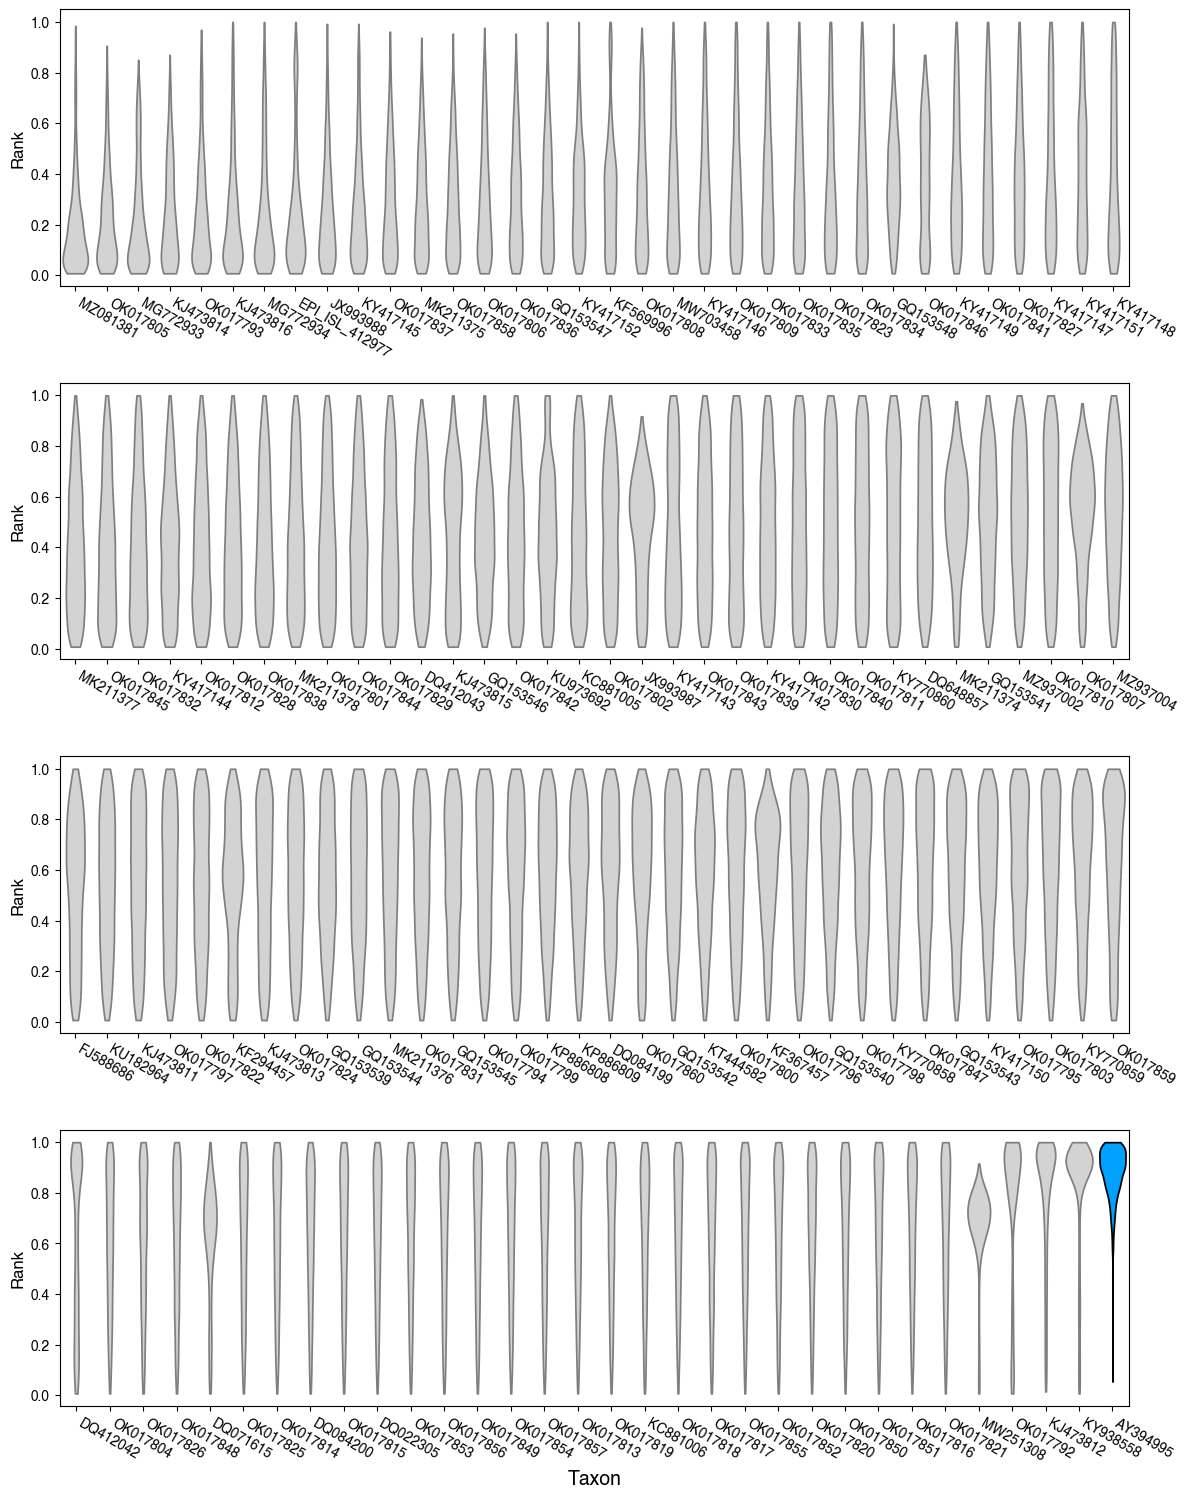

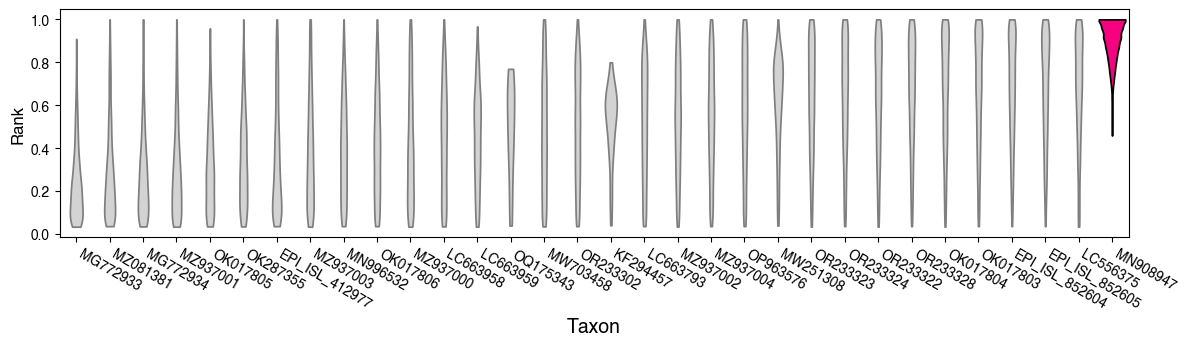

In [8]:
def sort_melted_df(df, key_col, val_col, method='mean'):

    if method == 'median':
        # Group by 'keys' and calculate the median for each group
        medians = df.groupby(key_col)[val_col].median()

        # Create a new DataFrame with keys and their corresponding medians
        median_df = pd.DataFrame({key_col: medians.index, 'median': medians.values})
        
        # Sort the DataFrame based on medians
        sorted_df = median_df.sort_values(by='median')

        # Merge the original DataFrame with the sorted DataFrame based on 'keys'
        merged_df = pd.merge(df, sorted_df, on=key_col)

        # Sort the merged DataFrame based on the order of keys in sorted_df
        final_sorted_df = merged_df.sort_values(by='median')

        # Drop the 'medians' column if you don't need it in the final result
        final_sorted_df = final_sorted_df.drop(columns='median')

    elif method == 'mean':
        # Group by 'keys' and calculate the mean for each group
        means = df.groupby(key_col)[val_col].mean()

        # Create a new DataFrame with keys and their corresponding means
        mean_df = pd.DataFrame({key_col: means.index, 'mean': means.values})
        
        # Sort the DataFrame based on means
        sorted_df = mean_df.sort_values(by='mean')

        # Merge the original DataFrame with the sorted DataFrame based on 'keys'
        merged_df = pd.merge(df, sorted_df, on=key_col)

        # Sort the merged DataFrame based on the order of keys in sorted_df
        final_sorted_df = merged_df.sort_values(by='mean')

        # Drop the 'means' column if you don't need it in the final result
        final_sorted_df = final_sorted_df.drop(columns='mean')

    # Now you have the original DataFrame sorted by keys based on median values
    return final_sorted_df


def violin_rank_tip_multi_rows(df, key_col, val_col, num_violins=34, figsize=(10, 6), outfile=None):
    """
    Plot multiple rows of violin plots to display the entire distribution for each x-value.
    """
    df = sort_melted_df(df, key_col=key_col, val_col=val_col, method='mean')
    df['tipLabel'] = df['tipLabel'].apply(lambda x: x.replace('SC1_', '').replace('SC2_', '').split('.')[0])

    plt.figure(figsize=figsize)

    # Calculate the number of subplots needed
    num_subplots = int(len(df[key_col].unique()) / num_violins) + 1
    num_cols = 1  # Ensure num_cols is not greater than num_subplots
    num_rows = int(num_subplots / num_cols) + 1
    # print(num_rows, num_cols, num_subplots)
    for i in range(num_subplots):
        # Create a subplot grid with num_rows rows and num_cols columns
        plt.subplot(num_rows, num_cols, i + 1)

        # Filter data for the current subplot
        start_idx = i * num_violins
        end_idx = (i + 1) * num_violins
        subset_df = df[df[key_col].isin(df[key_col].unique()[start_idx:end_idx])]

        # Plot violin plots for the subset
        if i == num_subplots - 1:  # Check if it's the last subplot
            sns.violinplot(data=subset_df, x=key_col, y=val_col, inner=None, color='lightgray', zorder=0, cut=0)
        else:
            sns.violinplot(data=subset_df, x=key_col, y=val_col, inner=None, color='lightgray', zorder=0, cut=0)
        
        plt.xticks(rotation=-30, ha='left', fontsize=10)
        plt.ylabel('Rank', fontsize=12)

        # xlabel
        if i < num_subplots - 1:
            plt.gca().set_xlabel('')
        else:
            plt.gca().set_xlabel('Taxon', fontsize=14)

    # After plotting all the violins, identify the last violin in the last subplot and set its color to red
    sc1_color = '#00a0ff'
    sc2_color = '#f50280'
    if 'MN908947' in df['tipLabel'].unique():
        last_violin = plt.gcf().get_axes()[-1].collections[-1]
        last_violin.set_facecolor(sc2_color)
        # color outline black
        last_violin.set_edgecolor('black')
    elif 'AY394995' in df['tipLabel'].unique():
        last_subplot = plt.gcf().get_axes()[-1]
        last_violin = last_subplot.collections[-1]
        last_violin.set_facecolor(sc1_color)
        # color outline black
        last_violin.set_edgecolor('black')

    plt.tight_layout()

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

sc1_results_filtered_df = filter_by_age(sc1_results_df, sc=1, threshold=50)
sc2_late2020_results_filtered_df = filter_by_age(sc2_late2020_results_df, sc=2, threshold=50)

sc1_results_filtered_df = rank_tips(sc1_results_filtered_df, column = 'dispersal_velocity')
sc2_late2020_results_filtered_df = rank_tips(sc2_late2020_results_filtered_df, column = 'dispersal_velocity')

violin_rank_tip_multi_rows(sc1_results_filtered_df, key_col='tipLabel', val_col='rank', num_violins=34, figsize=(12, 18), outfile=None)
violin_rank_tip_multi_rows(sc2_late2020_results_filtered_df, key_col='tipLabel', val_col='rank', num_violins=34, figsize=(12, 6), outfile=None)

# 5. Joint plots for text: primary analysis

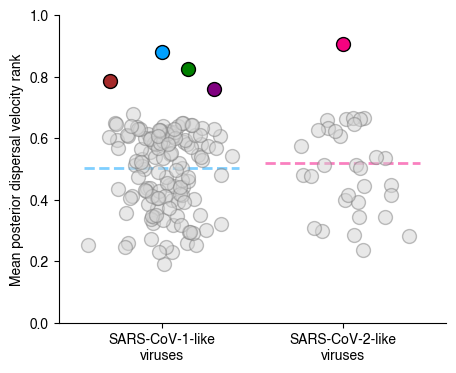

/var/folders/ls/3swb_7515hv8jb0mjxshss480000gp/T/ipykernel_35246/4117440882.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(x) for x in major_yticks], minor=False)


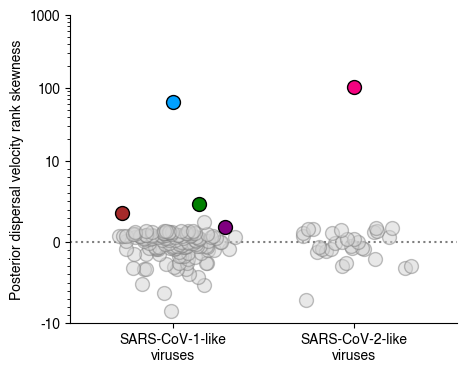

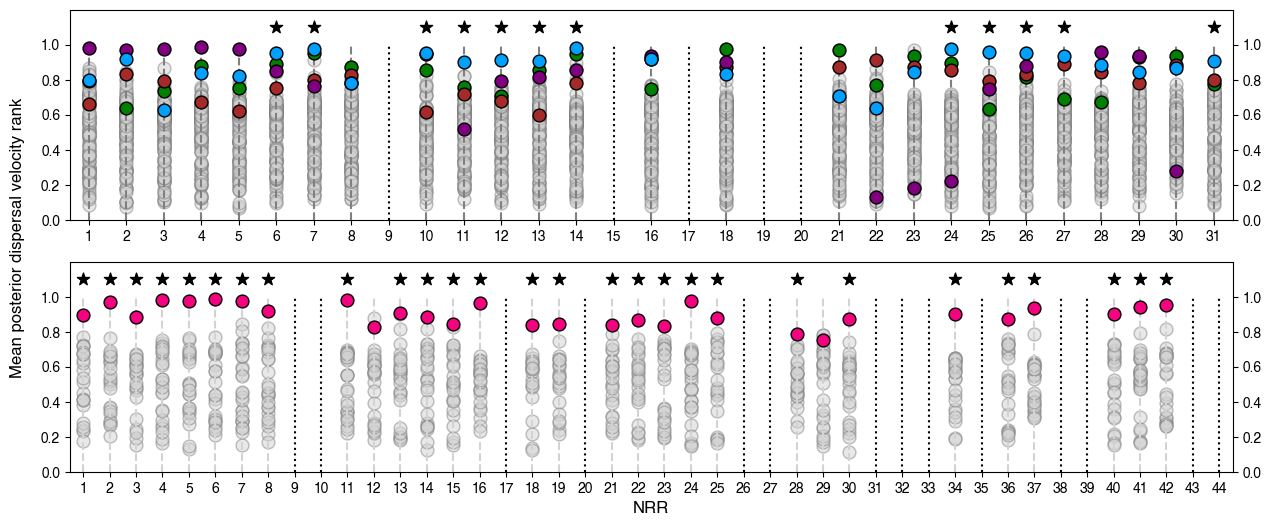

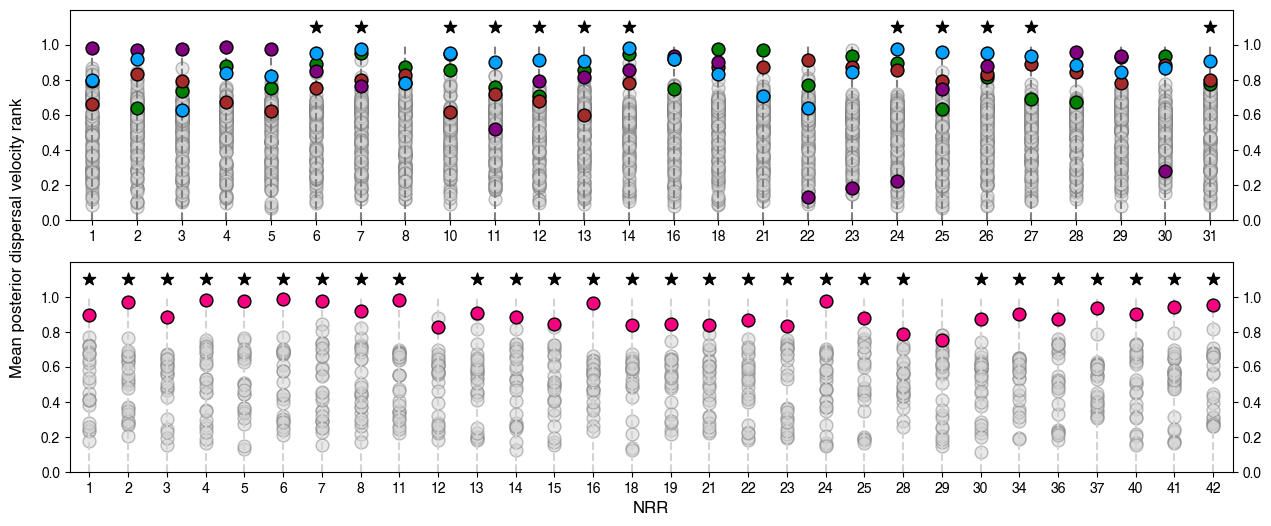

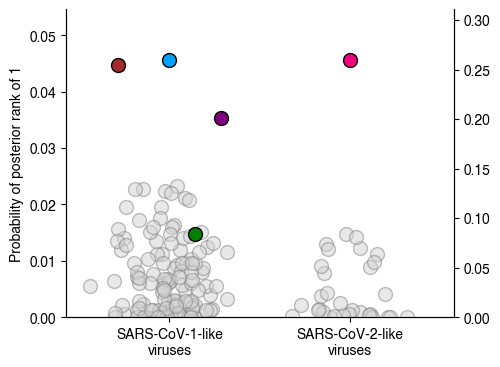

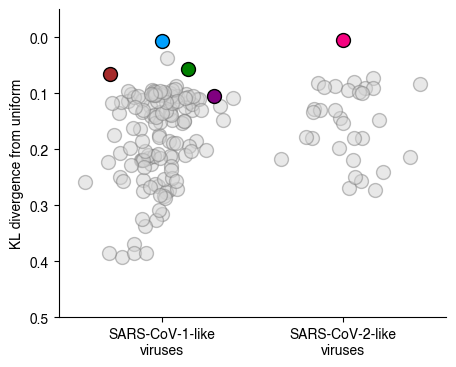

In [5]:
# Define the custom function to calculate skewness using the given mean
def custom_skewness(data, given_mean):
    # Calculate the standard deviation of the data
    std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    # Calculate the adjusted skewness using the given mean
    skewness = (len(data) * sum((item - given_mean)**3 for item in data) / 
                ((len(data) - 1) * (len(data) - 2) * std_dev**3))
    return skewness


def skewness_df(tip_rank_results_df, key_col='tipLabel', val_col='rank', given_mean=0.5):    
    skewness_results = []
    for key in tip_rank_results_df[key_col].unique():
        skew = custom_skewness(tip_rank_results_df[tip_rank_results_df[key_col]==key][val_col], given_mean=given_mean)
        skewness_results.append([key, skew])

    skew_df = pd.DataFrame(skewness_results, columns=['tip', 'skewness'])
    skew_df = skew_df.sort_values(by='skewness', ascending=True)

    return skew_df


def plot_text_skewness(sc1_skew_df, sc2_skew_df, outfile=None, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    sc1_color = '#00a0ff'
    sc2_color = '#f50280'
    diff=0.65
    s=100
    plt.scatter(x=[1]*(len(sc1_skew_df)-4) + np.random.normal(0, 0.05, len(sc1_skew_df)-4),
                y=sc1_skew_df[~sc1_skew_df['tip'].isin(['SC1_AY394995.1', 'SC1_KY938558.1', 'SC1_KJ473812.1', 'SC1_OK017792.1'])]['skewness'],
                color='lightgrey', 
                marker='o', 
                alpha=.5, 
                edgecolors='grey',
                s=s)
    # add scatter for AY394995.1
    plt.scatter(x=[1], 
                y=sc1_skew_df[sc1_skew_df['tip'] == 'SC1_AY394995.1']['skewness'],
                color=sc1_color, 
                marker='o', 
                edgecolors='black',
                s=s)
    plt.scatter(x=[1.05], 
                y=sc1_skew_df[sc1_skew_df['tip'] == 'SC1_KY938558.1']['skewness'],
                color='green', 
                marker='o', 
                edgecolors='black',
                s=s)
    plt.scatter(x=[.9],
                y=sc1_skew_df[sc1_skew_df['tip'] == 'SC1_KJ473812.1']['skewness'],
                color='brown',
                marker='o',
                edgecolors='black',
                s=s)

    plt.scatter(x=[1.1],
                y=sc1_skew_df[sc1_skew_df['tip'] == 'SC1_OK017792.1']['skewness'],
                color='purple',
                marker='o',
                edgecolors='black',
                s=s)
    
    if 'Ghost1' in sc1_skew_df['tip'].unique():
        plt.scatter(x=[1], 
                    y=sc1_skew_df[sc1_skew_df['tip'] == 'Ghost1']['skewness'],
                    color='lemonchiffon', 
                    marker='o', 
                    edgecolors='black',
                    s=s)
        plt.scatter(x=[1], 
                    y=sc1_skew_df[sc1_skew_df['tip'] == 'Ghost2']['skewness'],
                    color='lemonchiffon', 
                    marker='o', 
                    edgecolors='black',
                    s=s)

    # 
    plt.scatter(x=[2-diff]*(len(sc2_skew_df)-1) + np.random.normal(0, 0.05, len(sc2_skew_df)-1),
                y=sc2_skew_df[sc2_skew_df['tip'] != 'SC2_MN908947.3']['skewness'],
                color='lightgrey', 
                marker='o', 
                alpha=.5, 
                edgecolors='grey',
                s=s)
    # add scatter for MN908947.3
    plt.scatter(x=[2-diff], 
                y=sc2_skew_df[sc2_skew_df['tip'] == 'SC2_MN908947.3']['skewness'], 
                color=sc2_color, 
                marker='o', 
                edgecolors='black',
                s=s)
    
    if 'Ghost1' in sc2_skew_df['tip'].unique():
        plt.scatter(x=[2-diff], 
                    y=sc2_skew_df[sc2_skew_df['tip'] == 'Ghost1']['skewness'],
                    color='lemonchiffon', 
                    marker='o', 
                    edgecolors='black',
                    s=s)
        plt.scatter(x=[2-diff], 
                    y=sc2_skew_df[sc2_skew_df['tip'] == 'Ghost2']['skewness'],
                    color='lemonchiffon', 
                    marker='o', 
                    edgecolors='black',
                    s=s)

    plt.axhline(y=0, color='black', linestyle=':', alpha=0.5, zorder=0)

    plt.yscale('symlog', linthresh=10)
    plt.xlim(0.8, 2.2-diff)
    plt.ylim(-10, 100)

    plt.xticks([1, 2-diff])
    plt.gca().set_xticklabels(['SARS-CoV-1-like\nviruses', 'SARS-CoV-2-like\nviruses'])


    major_yticks = [-10,0,10,100,1000]
    minor_yticks = np.arange(-10, 10, 1).tolist() + np.arange(10, 100, 10).tolist() + np.arange(100, 1000, 100).tolist()
    plt.gca().set_yticks(major_yticks + minor_yticks, minor=True)
    # add ytick labels for major yticks
    plt.gca().set_yticklabels([str(x) for x in major_yticks], minor=False)
    plt.ylim(-10.001,1000)
    plt.ylabel('Posterior dispersal velocity rank skewness')

    # remove borders on top and right
    sns.despine()

    # custom legend 
    s=100
    plt.scatter([], [], color=sc1_color, marker='o', edgecolors='black', label='SARS-CoV-1 (HSZ-Cc)'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_AY394995.1
    plt.scatter([], [], color='green', marker='o', edgecolors='black', label='16BO133'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_KY938558.1
    plt.scatter([], [], color='brown', marker='o', edgecolors='black', label='BtRf-HeB2013'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_KJ473812.1
    plt.scatter([], [], color='purple', marker='o', edgecolors='black', label='GD2017F'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_OK017792.1
    plt.scatter([], [], color=sc2_color, marker='o', edgecolors='black', label='SARS-CoV-2 (Hu-1)'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC2_MN908947.3
    if 'Ghost1' in sc1_skew_df['tip'].unique():
        plt.scatter([], [], color='lemonchiffon', marker='o', edgecolors='black', label='Ghost', s=s)
    # plt.legend(loc='upper left', bbox_to_anchor=(.95, 1), frameon=False)

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        
    plt.show()
    plt.close()


def plot_text_median_rank(sc1_results_tips_df, sc2_results_tips_df, outfile=None, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    sc1_color = '#00a0ff'
    sc2_color = '#f50280'
    diff=0.65
    s=100
    plt.scatter(x=[1]*(len(sc1_results_tips_df['tipLabel'].unique())-4) + np.random.normal(0, 0.05, len(sc1_results_tips_df['tipLabel'].unique())-4), y=sc1_results_tips_df[~sc1_results_tips_df['tipLabel'].isin(['SC1_AY394995.1', 'SC1_KY938558.1', 'SC1_KJ473812.1', 'SC1_OK017792.1'])].groupby('tipLabel')['rank'].median(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)

    plt.scatter(x=[1], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_AY394995.1']['rank'].median(), color=sc1_color, marker='o', edgecolors='black', s=s)
    plt.scatter(x=[1.05], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_KY938558.1']['rank'].median(), color='green', marker='o', edgecolors='black', s=s)
    plt.scatter(x=[.9], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_KJ473812.1']['rank'].median(), color='brown', marker='o', edgecolors='black', s=s)
    plt.scatter(x=[1.1], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_OK017792.1']['rank'].median(), color='purple', marker='o', edgecolors='black', s=s)
    if 'Ghost1' in sc1_results_tips_df['tipLabel'].unique():
        plt.scatter(x=[1.02], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'Ghost1']['rank'].median(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
        plt.scatter(x=[0.97], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'Ghost2']['rank'].median(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

    plt.scatter(x=[2-diff]*(len(sc2_results_tips_df['tipLabel'].unique())-1) + np.random.normal(0, 0.05, len(sc2_results_tips_df['tipLabel'].unique())-1), y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] != 'SC2_MN908947.3'].groupby('tipLabel')['rank'].median(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)

    plt.scatter(x=[2-diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'SC2_MN908947.3']['rank'].median(), color=sc2_color, marker='o', edgecolors='black', s=s)
    if 'Ghost1' in sc2_results_tips_df['tipLabel'].unique():
        plt.scatter(x=[2.03-diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'Ghost1']['rank'].median(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
        plt.scatter(x=[1.93-diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'Ghost2']['rank'].median(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

    plt.hlines(xmin=0.85, xmax=1.15, y=sc1_results_tips_df['rank'].median(), color=sc1_color, linestyle='--', alpha=0.5, zorder=0, linewidth=2)
    plt.hlines(xmin=1.85-diff, xmax=2.15-diff, y=sc2_results_tips_df['rank'].median(), color=sc2_color, linestyle='--', alpha=0.5, zorder=0, linewidth=2)

    plt.xlim(0.8, 2.2-diff)
    plt.ylim(0, 1)

    plt.xticks([1, 2-diff])
    plt.gca().set_xticklabels(['SARS-CoV-1-like\nviruses', 'SARS-CoV-2-like\nviruses'])

    plt.ylabel('Median posterior dispersal velocity rank')
    sns.despine()

    # custom legend
    s=100
    plt.scatter([], [], color=sc1_color, marker='o', edgecolors='black', label='SARS-CoV-1 (HSZ-Cc)'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_AY394995.1
    plt.scatter([], [], color='green', marker='o', edgecolors='black', label='16BO133'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_KY938558.1
    plt.scatter([], [], color='brown', marker='o', edgecolors='black', label='BtRf-HeB2013'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_KJ473812.1
    plt.scatter([], [], color='purple', marker='o', edgecolors='black', label='GD2017F'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_OK017792.1
    plt.scatter([], [], color=sc2_color, marker='o', edgecolors='black', label='SARS-CoV-2 (Hu-1)'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC2_MN908947.3
    # if 'Ghost1' in sc1_skew_df['tip'].unique():
    #     plt.scatter([], [], color='lemonchiffon', marker='o', edgecolors='black', label='Ghost', s=s)
    plt.legend(loc='upper left', bbox_to_anchor=(.95, 1), frameon=False)

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        
    plt.show()
    plt.close()


def plot_text_mean_rank(sc1_results_tips_df, sc2_results_tips_df, outfile=None, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    sc1_color = '#00a0ff'
    sc2_color = '#f50280'
    diff=0.65
    s=100
    plt.scatter(x=[1]*(len(sc1_results_tips_df['tipLabel'].unique())-4) + np.random.normal(0, 0.05, len(sc1_results_tips_df['tipLabel'].unique())-4), y=sc1_results_tips_df[~sc1_results_tips_df['tipLabel'].isin(['SC1_AY394995.1', 'SC1_KY938558.1', 'SC1_KJ473812.1', 'SC1_OK017792.1'])].groupby('tipLabel')['rank'].mean(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)

    plt.scatter(x=[1], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_AY394995.1']['rank'].mean(), color=sc1_color, marker='o', edgecolors='black', s=s)
    plt.scatter(x=[1.05], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_KY938558.1']['rank'].mean(), color='green', marker='o', edgecolors='black', s=s)
    plt.scatter(x=[.9], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_KJ473812.1']['rank'].mean(), color='brown', marker='o', edgecolors='black', s=s)
    plt.scatter(x=[1.1], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_OK017792.1']['rank'].mean(), color='purple', marker='o', edgecolors='black', s=s)
    if 'Ghost1' in sc1_results_tips_df['tipLabel'].unique():
        plt.scatter(x=[1.02], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'Ghost1']['rank'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
        plt.scatter(x=[0.97], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'Ghost2']['rank'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

    plt.scatter(x=[2-diff]*(len(sc2_results_tips_df['tipLabel'].unique())-1) + np.random.normal(0, 0.05, len(sc2_results_tips_df['tipLabel'].unique())-1), y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] != 'SC2_MN908947.3'].groupby('tipLabel')['rank'].mean(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)

    plt.scatter(x=[2-diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'SC2_MN908947.3']['rank'].mean(), color=sc2_color, marker='o', edgecolors='black', s=s)
    if 'Ghost1' in sc2_results_tips_df['tipLabel'].unique():
        plt.scatter(x=[2.03-diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'Ghost1']['rank'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
        plt.scatter(x=[1.93-diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'Ghost2']['rank'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

    plt.hlines(xmin=0.85, xmax=1.15, y=sc1_results_tips_df['rank'].mean(), color=sc1_color, linestyle='--', alpha=0.5, zorder=0, linewidth=2)
    plt.hlines(xmin=1.85-diff, xmax=2.15-diff, y=sc2_results_tips_df['rank'].mean(), color=sc2_color, linestyle='--', alpha=0.5, zorder=0, linewidth=2)

    plt.xlim(0.8, 2.2-diff)
    plt.ylim(0, 1)

    plt.xticks([1, 2-diff])
    plt.gca().set_xticklabels(['SARS-CoV-1-like\nviruses', 'SARS-CoV-2-like\nviruses'])

    plt.ylabel('Mean posterior dispersal velocity rank')
    sns.despine()

    # custom legend
    s=100
    plt.scatter([], [], color=sc1_color, marker='o', edgecolors='black', label='SC1_AY394995.1', s=s)
    plt.scatter([], [], color='green', marker='o', edgecolors='black', label='SC1_KY938558.1', s=s)
    plt.scatter([], [], color='brown', marker='o', edgecolors='black', label='SC1_KJ473812.1', s=s)
    plt.scatter([], [], color='purple', marker='o', edgecolors='black', label='SC1_OK017792.1', s=s)
    plt.scatter([], [], color=sc2_color, marker='o', edgecolors='black', label='SC2_MN908947.3', s=s)
    # plt.legend(loc='upper left', bbox_to_anchor=(.95, 1), frameon=False)

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        
    plt.show()
    plt.close()


def plot_text_median_rank(sc1_results_tips_df, sc2_results_tips_df, outfile=None, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    sc1_color = '#00a0ff'
    sc2_color = '#f50280'
    diff=0.65
    s=100
    plt.scatter(x=[1]*(len(sc1_results_tips_df['tipLabel'].unique())-4) + np.random.normal(0, 0.05, len(sc1_results_tips_df['tipLabel'].unique())-4), y=sc1_results_tips_df[~sc1_results_tips_df['tipLabel'].isin(['SC1_AY394995.1', 'SC1_KY938558.1', 'SC1_KJ473812.1', 'SC1_OK017792.1'])].groupby('tipLabel')['rank'].median(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)

    plt.scatter(x=[1], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_AY394995.1']['rank'].median(), color=sc1_color, marker='o', edgecolors='black', s=s)
    plt.scatter(x=[1.05], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_KY938558.1']['rank'].median(), color='green', marker='o', edgecolors='black', s=s)
    plt.scatter(x=[.9], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_KJ473812.1']['rank'].median(), color='brown', marker='o', edgecolors='black', s=s)
    plt.scatter(x=[1.1], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_OK017792.1']['rank'].median(), color='purple', marker='o', edgecolors='black', s=s)
    if 'Ghost1' in sc1_results_tips_df['tipLabel'].unique():
        plt.scatter(x=[1.02], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'Ghost1']['rank'].median(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
        plt.scatter(x=[0.97], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'Ghost2']['rank'].median(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

    plt.scatter(x=[2-diff]*(len(sc2_results_tips_df['tipLabel'].unique())-1) + np.random.normal(0, 0.05, len(sc2_results_tips_df['tipLabel'].unique())-1), y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] != 'SC2_MN908947.3'].groupby('tipLabel')['rank'].median(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)

    plt.scatter(x=[2-diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'SC2_MN908947.3']['rank'].median(), color=sc2_color, marker='o', edgecolors='black', s=s)
    if 'Ghost1' in sc2_results_tips_df['tipLabel'].unique():
        plt.scatter(x=[2.03-diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'Ghost1']['rank'].median(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
        plt.scatter(x=[1.93-diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'Ghost2']['rank'].median(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

    plt.hlines(xmin=0.85, xmax=1.15, y=sc1_results_tips_df['rank'].median(), color=sc1_color, linestyle='--', alpha=0.5, zorder=0, linewidth=2)
    plt.hlines(xmin=1.85-diff, xmax=2.15-diff, y=sc2_results_tips_df['rank'].median(), color=sc2_color, linestyle='--', alpha=0.5, zorder=0, linewidth=2)

    plt.xlim(0.8, 2.2-diff)
    plt.ylim(0, 1)

    plt.xticks([1, 2-diff])
    plt.gca().set_xticklabels(['SARS-CoV-1-like\nviruses', 'SARS-CoV-2-like\nviruses'])

    plt.ylabel('Median posterior dispersal velocity rank')
    sns.despine()

    # custom legend
    s=100
    plt.scatter([], [], color=sc1_color, marker='o', edgecolors='black', label='SARS-CoV-1 (HSZ-Cc)'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_AY394995.1
    plt.scatter([], [], color='green', marker='o', edgecolors='black', label='16BO133'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_KY938558.1
    plt.scatter([], [], color='brown', marker='o', edgecolors='black', label='BtRf-HeB2013'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_KJ473812.1
    plt.scatter([], [], color='purple', marker='o', edgecolors='black', label='GD2017F'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC1_OK017792.1
    plt.scatter([], [], color=sc2_color, marker='o', edgecolors='black', label='SARS-CoV-2 (Hu-1)'.replace('SC1_', '').replace('SC2_', '').split('.')[0], s=s) # SC2_MN908947.3
    # if 'Ghost1' in sc1_skew_df['tip'].unique():
    #     plt.scatter([], [], color='lemonchiffon', marker='o', edgecolors='black', label='Ghost', s=s)
    plt.legend(loc='upper left', bbox_to_anchor=(.95, 1), frameon=False)


    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()


def plot_text_probability_rank1(sc1_results_tips_df, sc2_results_tips_df, outfile=None, figsize=(6, 6)):
    fig, ax1 = plt.subplots(figsize=figsize)

    sc1_color = '#00a0ff'
    sc2_color = '#f50280'
    diff = 0.65
    s = 100

    # calculate how often each tip is rank 1, divided by the number of occurrences of that tip in the dataset
    sc1_results_tips_df['prob_rank1'] = sc1_results_tips_df.groupby('tipLabel')['rank'].transform(lambda x: (x == 1).sum() / len(x))
    sc2_results_tips_df['prob_rank1'] = sc2_results_tips_df.groupby('tipLabel')['rank'].transform(lambda x: (x == 1).sum() / len(x))


    # First subplot for SC1
    ax1.scatter(x=[1] * (len(sc1_results_tips_df['tipLabel'].unique()) - 4) + np.random.normal(0, 0.05, len(sc1_results_tips_df['tipLabel'].unique()) - 4), y=sc1_results_tips_df[~sc1_results_tips_df['tipLabel'].isin(['SC1_AY394995.1', 'SC1_KY938558.1', 'SC1_KJ473812.1', 'SC1_OK017792.1'])].groupby('tipLabel')['prob_rank1'].mean(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)
    ax1.scatter(x=[1], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_AY394995.1']['prob_rank1'].mean(), color=sc1_color, marker='o', edgecolors='black', s=s)
    ax1.scatter(x=[1.05], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_KY938558.1']['prob_rank1'].mean(), color='green', marker='o', edgecolors='black', s=s)
    ax1.scatter(x=[.9], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_KJ473812.1']['prob_rank1'].mean(), color='brown', marker='o', edgecolors='black', s=s)
    ax1.scatter(x=[1.1], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_OK017792.1']['prob_rank1'].mean(), color='purple', marker='o', edgecolors='black', s=s)
    if 'Ghost1' in sc1_results_tips_df['tipLabel'].unique():
        ax1.scatter(x=[1.02], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'Ghost1']['prob_rank1'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
        ax1.scatter(x=[0.97], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'Ghost2']['prob_rank1'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

    ax1.set_xlim(0.8, 2.2 - diff)
    ax1.set_ylim(0, sc1_results_tips_df['prob_rank1'].max()*1.2)
    ax1.set_xticks([1])
    ax1.set_xticklabels(['SARS-CoV-1-like\nviruses'])
    ax1.set_ylabel('Probability of posterior rank of 1')

    # Second subplot for SC2
    ax2 = ax1.twinx()
    ax2.scatter(x=[2 - diff] * (len(sc2_results_tips_df['tipLabel'].unique()) - 1) + np.random.normal(0, 0.05, len(sc2_results_tips_df['tipLabel'].unique()) - 1), y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] != 'SC2_MN908947.3'].groupby('tipLabel')['prob_rank1'].mean(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)
    ax2.scatter(x=[2 - diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'SC2_MN908947.3']['prob_rank1'].mean(), color=sc2_color, marker='o', edgecolors='black', s=s)
    if 'Ghost1' in sc2_results_tips_df['tipLabel'].unique():
        ax2.scatter(x=[2.03 - diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'Ghost1']['prob_rank1'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
        ax2.scatter(x=[1.93 - diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'Ghost2']['prob_rank1'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

    ax2.set_xlim(0.8, 2.2 - diff)
    ax2.set_ylim(0, sc2_results_tips_df['prob_rank1'].max()*1.2)
    ax2.set_xticks([1, 2 - diff])
    ax2.set_xticklabels(['SARS-CoV-1-like\nviruses', 'SARS-CoV-2-like\nviruses'])

    # remove top border
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        
    plt.show()
    plt.close()


# def plot_text_kl_divergence(sc1_results_tips_df, sc2_results_tips_df, outfile=None, figsize=(6, 6)):
#     fig, ax1 = plt.subplots(figsize=figsize)

#     sc1_color = '#00a0ff'
#     sc2_color = '#f50280'
#     diff = 0.65
#     s = 100

#     # entropy function
#     def entropy(pk, qk=None, base=None, axis=0):
#         pk = np.asarray(pk)
#         pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
#         if qk is None:
#             vec = entropy(pk, base=base, axis=axis)
#         else:
#             qk = np.asarray(qk)
#             qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)
#             vec = entropy(pk, base=base, axis=axis) - entropy(qk, base=base, axis=axis)
#         return vec
    

#     # calculate the KL divergence for each tip
#     sc1_results_tips_df['kl_divergence'] = sc1_results_tips_df.groupby('tipLabel')['rank'].transform(lambda x: entropy(x, qk=[1/len(x)]*len(x)))
#     sc2_results_tips_df['kl_divergence'] = sc2_results_tips_df.groupby('tipLabel')['rank'].transform(lambda x: entropy(x, qk=[1/len(x)]*len(x)))

#     # First subplot for SC1
#     ax1.scatter(x=[1] * (len(sc1_results_tips_df['tipLabel'].unique()) - 4) + np.random.normal(0, 0.05, len(sc1_results_tips_df['tipLabel'].unique()) - 4), y=sc1_results_tips_df[~sc1_results_tips_df['tipLabel'].isin(['SC1_AY394995.1', 'SC1_KY938558.1', 'SC1_KJ473812.1', 'SC1_OK017792.1'])].groupby('tipLabel')['kl_divergence'].mean(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)
#     ax1.scatter(x=[1], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_AY394995.1']['kl_divergence'].mean(), color=sc1_color, marker='o', edgecolors='black', s=s)
#     ax1.scatter(x=[1.05], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_KY938558.1']['kl_divergence'].mean(), color='green', marker='o', edgecolors='black', s=s)
#     ax1.scatter(x=[.9], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_KJ473812.1']['kl_divergence'].mean(), color='brown', marker='o', edgecolors='black', s=s)
#     ax1.scatter(x=[1.1], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'SC1_OK017792.1']['kl_divergence'].mean(), color='purple', marker='o', edgecolors='black', s=s)
#     if 'Ghost1' in sc1_results_tips_df['tipLabel'].unique():
#         ax1.scatter(x=[1.02], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'Ghost1']['kl_divergence'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
#         ax1.scatter(x=[0.97], y=sc1_results_tips_df[sc1_results_tips_df['tipLabel'] == 'Ghost2']['kl_divergence'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

#     ax1.set_xlim(0.8, 2.2 - diff)
#     ax1.set_ylim(0, sc1_results_tips_df['kl_divergence'].max()*1.2)
#     ax1.set_xticks([1])
#     ax1.set_xticklabels(['SARS-CoV-1-like\nviruses'])
#     ax1.set_ylabel('KL divergence from uniform')

#     # Second subplot for SC2
#     ax2 = ax1.twinx()
#     ax2.scatter(x=[2 - diff] * (len(sc2_results_tips_df['tipLabel'].unique()) - 1) + np.random.normal(0, 0.05, len(sc2_results_tips_df['tipLabel'].unique()) - 1), y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] != 'SC2_MN908947.3'].groupby('tipLabel')['kl_divergence'].mean(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)
#     ax2.scatter(x=[2 - diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'SC2_MN908947.3']['kl_divergence'].mean(), color=sc2_color, marker='o', edgecolors='black', s=s)
#     if 'Ghost1' in sc2_results_tips_df['tipLabel'].unique():
#         ax2.scatter(x=[2.03 - diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'Ghost1']['kl_divergence'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
#         ax2.scatter(x=[1.93 - diff], y=sc2_results_tips_df[sc2_results_tips_df['tipLabel'] == 'Ghost2']['kl_divergence'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

#     ax2.set_xlim(0.8, 2.2 - diff)
#     ax2.set_ylim(0, sc2_results_tips_df['kl_divergence'].max()*1.2)
#     ax2.set_xticks([1, 2 - diff])
#     ax2.set_xticklabels(['SARS-CoV-1-like\nviruses', 'SARS-CoV-2-like\nviruses'])

#     # remove top border
#     ax1.spines['top'].set_visible(False)
#     ax2.spines['top'].set_visible(False)

#     if outfile:
#         plt.savefig(outfile, dpi=300, bbox_inches='tight')

#     plt.show()
#     plt.close()
        

def plot_text_nrr_mean_rank(sc1_results_tips_df, sc2_results_tips_df, outfile=None, figsize=(15, 6)):
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=False)

    s=85
    sc1_color = '#00a0ff'
    sc2_color = '#f50280'

    ax1 = plt.subplot(2, 1, 1)
    sc1_nrr_results = []
    for nrr in sc1_results_tips_df['NRR'].unique():
        x = nrr
        y1 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] != 'SC1_AY394995.1') & (sc1_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].mean())
        y2 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_AY394995.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].mean())
        y3 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_KY938558.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].mean())
        y4 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_KJ473812.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].mean())
        y5 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_OK017792.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].mean())
        y6 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'].isin(['Ghost1', 'Ghost2'])) & (sc1_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].mean())
        sc1_nrr_results.append([x, y1, y2, y3, y4, y5, y6])

    # plot the results
    for nrr in sc1_nrr_results:
        ax1.scatter(x=[nrr[0]]*len(nrr[1]), y=nrr[1], color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s, zorder=0)
        ax1.scatter(x=[nrr[0]], y=nrr[2], color=sc1_color, marker='o', edgecolors='black', s=s, zorder=100)
        ax1.scatter(x=[nrr[0]], y=nrr[3], color='green', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]], y=nrr[4], color='brown', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]], y=nrr[5], color='purple', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]]*len(nrr[6]), y=nrr[6], color='lemonchiffon', marker='o', edgecolors='black', s=s, zorder=99)


    # add vline for each nrr 
    for nrr in sc1_results_tips_df['NRR'].unique():
        ax1.vlines(x=nrr, ymin=0, ymax=1, color='grey', linestyle='--', zorder=0)
    # if we are missing nrrs, add vlines for them
    if len(sc1_results_tips_df['NRR'].unique()) < 31:
        for nrr in range(1, 32):
            if nrr not in sc1_results_tips_df['NRR'].unique():
                ax1.vlines(x=nrr, ymin=0, ymax=1, color='black', linestyle=':', zorder=0)

    # place an asterisk at y=1.05 for every nrr where SC1_AY394995.1 has the highest rank
    count = 0
    prop = 0.75
    count_high_prop = 0
    count_sk_highest = 0
    for nrr in sc1_nrr_results:
        if nrr[2] >= max(nrr[1]):
            ax1.scatter(x=[nrr[0]], y=[1.1], color='black', marker='*', s=s)
            count += 1
        if nrr[2] >= prop:
            count_high_prop += 1
        if nrr[3] >= max(nrr[1]) and nrr[3] >= nrr[2]:
            count_sk_highest += 1
        #     print(nrr[0])
        # if nrr[0] == 19:
        #     print(nrr[2], nrr[3], max(nrr[1]))
    # print(count, count_high_prop, count_sk_highest)

    # xtick labels should include all nrrs
    ax1.set_xticks(sc1_results_tips_df['NRR'].unique())
    ax1.set_ylim([0,1.2])
    ax1.set_xlim([0.5, 31.5])
    ax1.set_yticks(np.arange(0, 1.05, 0.2))

    ax2 = plt.subplot(2, 1, 2)
    sc2_nrr_results = []
    for nrr in sc2_results_tips_df['NRR'].unique():
        x = nrr
        y1 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'] != 'SC2_MN908947.3') & (sc2_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].mean())
        y2 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'] == 'SC2_MN908947.3') & (sc2_results_tips_df['NRR'] == nrr)]['rank'].mean())
        y3 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'].isin(['Ghost1', 'Ghost2'])) & (sc2_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].mean())
        sc2_nrr_results.append([x, y1, y2, y3])

    # plot the results
    for nrr in sc2_nrr_results:
        ax2.scatter(x=[nrr[0]]*len(nrr[1]), y=nrr[1], color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s, zorder=0)
        ax2.scatter(x=[nrr[0]], y=nrr[2], color=sc2_color, marker='o', edgecolors='black', s=s, zorder=100)
        ax2.scatter(x=[nrr[0]]*len(nrr[3]), y=nrr[3], color='lemonchiffon', marker='o', edgecolors='black', s=s, zorder=99)

    # add vline for each nrr
    for nrr in sc2_results_tips_df['NRR'].unique():
        ax2.vlines(x=nrr, ymin=0, ymax=1, color='lightgray', linestyle='--', zorder=0)

    # if we are missing nrrs, add vlines for them
    if len(sc2_results_tips_df['NRR'].unique()) < 44:
        for nrr in range(1, 45):
            if nrr not in sc2_results_tips_df['NRR'].unique():
                ax2.vlines(x=nrr, ymin=0, ymax=1, color='black', linestyle=':', zorder=0)

    # place an asterisk at y=1.05 for every nrr where SC2_MN908947.3 has the highest rank
    count = 0
    count_high_prop = 0
    for nrr in sc2_nrr_results:
        if nrr[2] >= max(nrr[1]):
            ax2.scatter(x=[nrr[0]], y=[1.1], color='black', marker='*', s=s)
            count += 1
        if nrr[2] >= prop:
            count_high_prop += 1
    # print(count, count_high_prop)

    # xtick labels should include all nrrs
    ax2.set_xticks(sc2_results_tips_df['NRR'].unique())
    ax2.set_ylim([0, 1.2])
    ax2.set_xlim([0.5, 44.5])
    ax2.set_yticks(np.arange(0, 1.05, 0.2))
    # ax2.set_ylabel('Posterior mean dispersal velocity rank')

    # add yticks for left and right borders
    ax1.tick_params(right=True, labelright=True)
    ax2.tick_params(right=True, labelright=True)

    # add ylabel for the whole plot, not the subplots
    fig.text(.085, 0.5, 'Mean posterior dispersal velocity rank', va='center', rotation='vertical', fontsize=12)
    ax2.set_xlabel('NRR', fontsize=12)

    # make sure xlabels include all NRRs, including missing ones
    ax1.set_xticks(np.arange(1, 32, 1))
    ax2.set_xticks(np.arange(1, 45, 1))

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()
        
        
def plot_text_nrr_median_rank(sc1_results_tips_df, sc2_results_tips_df, outfile=None, figsize=(15, 6)):
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=False)

    s=85
    sc1_color = '#00a0ff'
    sc2_color = '#f50280'

    ax1 = plt.subplot(2, 1, 1)
    sc1_nrr_results = []
    for nrr in sc1_results_tips_df['NRR'].unique():
        x = nrr
        y1 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] != 'SC1_AY394995.1') & (sc1_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].median())
        y2 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_AY394995.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].median())
        y3 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_KY938558.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].median())
        y4 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_KJ473812.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].median())
        y5 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_OK017792.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].median())
        y6 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'].isin(['Ghost1', 'Ghost2'])) & (sc1_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].median())
        sc1_nrr_results.append([x, y1, y2, y3, y4, y5, y6])

    # plot the results
    for nrr in sc1_nrr_results:
        ax1.scatter(x=[nrr[0]]*len(nrr[1]), y=nrr[1], color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s, zorder=0)
        ax1.scatter(x=[nrr[0]], y=nrr[2], color=sc1_color, marker='o', edgecolors='black', s=s, zorder=100)
        ax1.scatter(x=[nrr[0]], y=nrr[3], color='green', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]], y=nrr[4], color='brown', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]], y=nrr[5], color='purple', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]]*len(nrr[6]), y=nrr[6], color='lemonchiffon', marker='o', edgecolors='black', s=s, zorder=99)


    # add vline for each nrr 
    for nrr in sc1_results_tips_df['NRR'].unique():
        ax1.vlines(x=nrr, ymin=0, ymax=1, color='grey', linestyle='--', zorder=0)
    # if we are missing nrrs, add vlines for them
    if len(sc1_results_tips_df['NRR'].unique()) < 31:
        for nrr in range(1, 32):
            if nrr not in sc1_results_tips_df['NRR'].unique():
                ax1.vlines(x=nrr, ymin=0, ymax=1, color='black', linestyle=':', zorder=0)

    # place an asterisk at y=1.05 for every nrr where SC1_AY394995.1 has the highest rank
    count = 0
    prop = 0.75
    count_high_prop = 0
    count_sk_highest = 0
    for nrr in sc1_nrr_results:
        if nrr[2] >= max(nrr[1]):
            ax1.scatter(x=[nrr[0]], y=[1.1], color='black', marker='*', s=s)
            count += 1
        if nrr[2] >= prop:
            count_high_prop += 1
        if nrr[3] >= max(nrr[1]) and nrr[3] >= nrr[2]:
            count_sk_highest += 1
    #         print(nrr[0])
    #     if nrr[0] == 19:
    #         print(nrr[2], nrr[3], max(nrr[1]))
    # print(count, count_high_prop, count_sk_highest)

    # xtick labels should include all nrrs
    ax1.set_xticks(sc1_results_tips_df['NRR'].unique())
    ax1.set_ylim([0,1.2])
    ax1.set_xlim([0.5, 31.5])
    ax1.set_yticks(np.arange(0, 1.05, 0.2))

    ax2 = plt.subplot(2, 1, 2)
    sc2_nrr_results = []
    for nrr in sc2_results_tips_df['NRR'].unique():
        x = nrr
        y1 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'] != 'SC2_MN908947.3') & (sc2_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].median())
        y2 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'] == 'SC2_MN908947.3') & (sc2_results_tips_df['NRR'] == nrr)]['rank'].median())
        y3 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'].isin(['Ghost1', 'Ghost2'])) & (sc2_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].median())
        sc2_nrr_results.append([x, y1, y2, y3])

    # plot the results
    for nrr in sc2_nrr_results:
        ax2.scatter(x=[nrr[0]]*len(nrr[1]), y=nrr[1], color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s, zorder=0)
        ax2.scatter(x=[nrr[0]], y=nrr[2], color=sc2_color, marker='o', edgecolors='black', s=s, zorder=100)
        ax2.scatter(x=[nrr[0]]*len(nrr[3]), y=nrr[3], color='lemonchiffon', marker='o', edgecolors='black', s=s, zorder=99)

    # add vline for each nrr
    for nrr in sc2_results_tips_df['NRR'].unique():
        ax2.vlines(x=nrr, ymin=0, ymax=1, color='lightgray', linestyle='--', zorder=0)

    # if we are missing nrrs, add vlines for them
    if len(sc2_results_tips_df['NRR'].unique()) < 44:
        for nrr in range(1, 45):
            if nrr not in sc2_results_tips_df['NRR'].unique():
                ax2.vlines(x=nrr, ymin=0, ymax=1, color='black', linestyle=':', zorder=0)

    # place an asterisk at y=1.05 for every nrr where SC2_MN908947.3 has the highest rank
    count = 0
    count_high_prop = 0
    for nrr in sc2_nrr_results:
        if nrr[2] >= max(nrr[1]):
            ax2.scatter(x=[nrr[0]], y=[1.1], color='black', marker='*', s=s)
            count += 1
        if nrr[2] >= prop:
            count_high_prop += 1
    # print(count, count_high_prop)

    # xtick labels should include all nrrs
    ax2.set_xticks(sc2_results_tips_df['NRR'].unique())
    ax2.set_ylim([0, 1.2])
    ax2.set_xlim([0.5, 44.5])
    ax2.set_yticks(np.arange(0, 1.05, 0.2))

    # add yticks for left and right borders
    ax1.tick_params(right=True, labelright=True)
    ax2.tick_params(right=True, labelright=True)

    # add ylabel for the whole plot, not the subplots
    fig.text(.085, 0.5, 'Median posterior dispersal velocity rank', va='center', rotation='vertical', fontsize=12)
    ax2.set_xlabel('NRR', fontsize=12)

    # make sure xlabels include all NRRs, including missing ones
    ax1.set_xticks(np.arange(1, 32, 1))
    ax2.set_xticks(np.arange(1, 45, 1))

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        plt.close()


def plot_text_nrr_mean_rank_adjusted(sc1_results_tips_df, sc2_results_tips_df, outfile=None, figsize=(15, 6)):
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=False)

    s=85
    sc1_color = '#00a0ff'
    sc2_color = '#f50280'

    ax1 = plt.subplot(2, 1, 1)
    sc1_nrr_results = []
    sc1_xticks = []
    sc1_xlabels = []
    for index, nrr in enumerate(sorted(sc1_results_tips_df['NRR'].unique())):
        x = index+1
        y1 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] != 'SC1_AY394995.1') & (sc1_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].mean())
        y2 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_AY394995.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].mean())
        y3 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_KY938558.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].mean())
        y4 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_KJ473812.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].mean())
        y5 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_OK017792.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].mean())
        y6 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'].isin(['Ghost1', 'Ghost2'])) & (sc1_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].mean())
        sc1_nrr_results.append([x, y1, y2, y3, y4, y5, y6])
        sc1_xticks.append(x)
        sc1_xlabels.append(nrr)

    # plot the results
    for nrr in sc1_nrr_results:
        ax1.scatter(x=[nrr[0]]*len(nrr[1]), y=nrr[1], color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s, zorder=0)
        ax1.scatter(x=[nrr[0]], y=nrr[2], color=sc1_color, marker='o', edgecolors='black', s=s, zorder=100)
        ax1.scatter(x=[nrr[0]], y=nrr[3], color='green', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]], y=nrr[4], color='brown', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]], y=nrr[5], color='purple', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]]*len(nrr[6]), y=nrr[6], color='lemonchiffon', marker='o', edgecolors='black', s=s, zorder=99)


    # add vline for each nrr 
    for nrr in sc1_xticks:
        ax1.vlines(x=nrr, ymin=0, ymax=1, color='grey', linestyle='--', zorder=0)

    # place an asterisk at y=1.05 for every nrr where SC1_AY394995.1 has the highest rank
    count = 0
    prop = 0.75
    count_high_prop = 0
    count_sk_highest = 0
    for nrr in sc1_nrr_results:
        if nrr[2] >= max(nrr[1]):
            ax1.scatter(x=[nrr[0]], y=[1.1], color='black', marker='*', s=s)
            count += 1
        if nrr[2] >= prop:
            count_high_prop += 1
        if nrr[3] >= max(nrr[1]) and nrr[3] >= nrr[2]:
            count_sk_highest += 1
    #         print(nrr[0])
    #     if nrr[0] == 19:
    #         print(nrr[2], nrr[3], max(nrr[1]))
    # print(count, count_high_prop, count_sk_highest)

    # xtick labels should include all nrrs
    # print(sc1_xticks)
    ax1.set_xticks(sc1_xticks)
    ax1.set_xticklabels(sc1_xlabels)
    ax1.set_ylim([0,1.2])
    ax1.set_xlim([min(sc1_xticks) - 0.5, max(sc1_xticks) + 0.5])
    ax1.set_yticks(np.arange(0, 1.05, 0.2))


    ax2 = plt.subplot(2, 1, 2)
    sc2_nrr_results = []
    sc2_xticks = []
    sc2_xlabels = []
    for index, nrr in enumerate(sorted(sc2_results_tips_df['NRR'].unique())):
        x = index+1
        y1 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'] != 'SC2_MN908947.3') & (sc2_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].mean())
        y2 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'] == 'SC2_MN908947.3') & (sc2_results_tips_df['NRR'] == nrr)]['rank'].mean())
        y3 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'].isin(['Ghost1', 'Ghost2'])) & (sc2_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].mean())
        sc2_nrr_results.append([x, y1, y2, y3])
        sc2_xticks.append(x)
        sc2_xlabels.append(nrr)

    # plot the results
    for nrr in sc2_nrr_results:
        ax2.scatter(x=[nrr[0]]*len(nrr[1]), y=nrr[1], color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s, zorder=0)
        ax2.scatter(x=[nrr[0]], y=nrr[2], color=sc2_color, marker='o', edgecolors='black', s=s, zorder=100)
        ax2.scatter(x=[nrr[0]]*len(nrr[3]), y=nrr[3], color='lemonchiffon', marker='o', edgecolors='black', s=s, zorder=99)

    # add vline for each nrr
    for nrr in sc2_xticks:
        ax2.vlines(x=nrr, ymin=0, ymax=1, color='lightgray', linestyle='--', zorder=0)

    # place an asterisk at y=1.05 for every nrr where SC2_MN908947.3 has the highest rank
    count = 0
    count_high_prop = 0
    for nrr in sc2_nrr_results:
        if nrr[2] >= max(nrr[1]):
            ax2.scatter(x=[nrr[0]], y=[1.1], color='black', marker='*', s=s)
            count += 1
        if nrr[2] >= prop:
            count_high_prop += 1
    # print(count, count_high_prop)

    # xtick labels should include all nrrs
    ax2.set_xticks(sc2_xticks)
    ax2.set_xticklabels(sc2_xlabels)
    ax2.set_ylim([0, 1.2])
    ax2.set_xlim([min(sc2_xticks) - 0.5, max(sc2_xticks) + 0.5])
    ax2.set_yticks(np.arange(0, 1.05, 0.2))
    # ax2.set_ylabel('Posterior mean dispersal velocity rank')

    # add yticks for left and right borders
    ax1.tick_params(right=True, labelright=True)
    ax2.tick_params(right=True, labelright=True)

    # add ylabel for the whole plot, not the subplots
    fig.text(.085, 0.5, 'Mean posterior dispersal velocity rank', va='center', rotation='vertical', fontsize=12)
    ax2.set_xlabel('NRR', fontsize=12)

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()


def plot_text_nrr_median_rank_adjusted(sc1_results_tips_df, sc2_results_tips_df, outfile=None, figsize=(15, 6)):
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=False)

    s=85
    sc1_color = '#00a0ff'
    sc2_color = '#f50280'

    ax1 = plt.subplot(2, 1, 1)
    sc1_nrr_results = []
    sc1_xticks = []
    sc1_xlabels = []
    for index, nrr in enumerate(sorted(sc1_results_tips_df['NRR'].unique())):
        x = index+1
        y1 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] != 'SC1_AY394995.1') & (sc1_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].median())
        y2 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_AY394995.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].median())
        y3 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_KY938558.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].median())
        y4 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_KJ473812.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].median())
        y5 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'] == 'SC1_OK017792.1') & (sc1_results_tips_df['NRR'] == nrr)]['rank'].median())
        y6 = (sc1_results_tips_df[(sc1_results_tips_df['tipLabel'].isin(['Ghost1', 'Ghost2'])) & (sc1_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].median())
        sc1_nrr_results.append([x, y1, y2, y3, y4, y5, y6])
        sc1_xticks.append(x)
        sc1_xlabels.append(nrr)

    # plot the results
    for nrr in sc1_nrr_results:
        ax1.scatter(x=[nrr[0]]*len(nrr[1]), y=nrr[1], color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s, zorder=0)
        ax1.scatter(x=[nrr[0]], y=nrr[2], color=sc1_color, marker='o', edgecolors='black', s=s, zorder=100)
        ax1.scatter(x=[nrr[0]], y=nrr[3], color='green', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]], y=nrr[4], color='brown', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]], y=nrr[5], color='purple', marker='o', edgecolors='black', s=s, zorder=99)
        ax1.scatter(x=[nrr[0]]*len(nrr[6]), y=nrr[6], color='lemonchiffon', marker='o', edgecolors='black', s=s, zorder=99)


    # add vline for each nrr 
    for nrr in sc1_xticks:
        ax1.vlines(x=nrr, ymin=0, ymax=1, color='grey', linestyle='--', zorder=0)

    # place an asterisk at y=1.05 for every nrr where SC1_AY394995.1 has the highest rank
    count = 0
    prop = 0.75
    count_high_prop = 0
    count_sk_highest = 0
    for nrr in sc1_nrr_results:
        if nrr[2] >= max(nrr[1]):
            ax1.scatter(x=[nrr[0]], y=[1.1], color='black', marker='*', s=s)
            count += 1
        if nrr[2] >= prop:
            count_high_prop += 1
        if nrr[3] >= max(nrr[1]) and nrr[3] >= nrr[2]:
            count_sk_highest += 1
    #         print(nrr[0])
    #     if nrr[0] == 19:
    #         print(nrr[2], nrr[3], max(nrr[1]))
    # print(count, count_high_prop, count_sk_highest)

    # xtick labels should include all nrrs
    ax1.set_xticks(sc1_xticks)
    ax1.set_xticklabels(sc1_xlabels)
    ax1.set_ylim([0,1.2])
    ax1.set_xlim([min(sc1_xticks) - 0.5, max(sc1_xticks) + 0.5])
    ax1.set_yticks(np.arange(0, 1.05, 0.2))


    ax2 = plt.subplot(2, 1, 2)
    sc2_nrr_results = []
    sc2_xticks = []
    sc2_xlabels = []
    for index, nrr in enumerate(sorted(sc2_results_tips_df['NRR'].unique())):
        x = index+1
        y1 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'] != 'SC2_MN908947.3') & (sc2_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].median())
        y2 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'] == 'SC2_MN908947.3') & (sc2_results_tips_df['NRR'] == nrr)]['rank'].median())
        y3 = (sc2_results_tips_df[(sc2_results_tips_df['tipLabel'].isin(['Ghost1', 'Ghost2'])) & (sc2_results_tips_df['NRR'] == nrr)].groupby('tipLabel')['rank'].median())
        sc2_nrr_results.append([x, y1, y2, y3])
        sc2_xticks.append(x)
        sc2_xlabels.append(nrr)

    # plot the results
    for nrr in sc2_nrr_results:
        ax2.scatter(x=[nrr[0]]*len(nrr[1]), y=nrr[1], color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s, zorder=0)
        ax2.scatter(x=[nrr[0]], y=nrr[2], color=sc2_color, marker='o', edgecolors='black', s=s, zorder=100)
        ax2.scatter(x=[nrr[0]]*len(nrr[3]), y=nrr[3], color='lemonchiffon', marker='o', edgecolors='black', s=s, zorder=99)

    # add vline for each nrr
    for nrr in sc2_xticks:
        ax2.vlines(x=nrr, ymin=0, ymax=1, color='lightgray', linestyle='--', zorder=0)

    # place an asterisk at y=1.05 for every nrr where SC2_MN908947.3 has the highest rank
    count = 0
    count_high_prop = 0
    for nrr in sc2_nrr_results:
        if nrr[2] >= max(nrr[1]):
            ax2.scatter(x=[nrr[0]], y=[1.1], color='black', marker='*', s=s)
            count += 1
        if nrr[2] >= prop:
            count_high_prop += 1
    # print(count, count_high_prop)

    # xtick labels should include all nrrs
    ax2.set_xticks(sc2_xticks)
    ax2.set_xticklabels(sc2_xlabels)
    ax2.set_ylim([0, 1.2])
    ax2.set_xlim([min(sc2_xticks) - 0.5, max(sc2_xticks) + 0.5])
    ax2.set_yticks(np.arange(0, 1.05, 0.2))

    # add yticks for left and right borders
    ax1.tick_params(right=True, labelright=True)
    ax2.tick_params(right=True, labelright=True)

    # add ylabel for the whole plot, not the subplots
    fig.text(.085, 0.5, 'Median posterior dispersal velocity rank', va='center', rotation='vertical', fontsize=12)
    ax2.set_xlabel('NRR', fontsize=12)

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        plt.close()



def plot_text_kl_divergence(sc1_results_tips_df, sc2_results_tips_df, outfile=None, figsize=(6, 6)):
    fig, ax1 = plt.subplots(figsize=figsize)

    sc1_color = '#00a0ff'
    sc2_color = '#f50280'
    diff = 0.65
    s = 100

    # calculate the KL divergence for each tip
    # sc1_kl_divergences = sc1_results_tips_df.groupby('tipLabel')['rank'].apply(lambda x: entropy(x, np.full_like(x, 1/len(x))))
    # sc2_kl_divergences = sc2_results_tips_df.groupby('tipLabel')['rank'].apply(lambda x: entropy(x, np.full_like(x, 1/len(x))))
    sc1_kl_divergences = sc1_results_tips_df.groupby('tipLabel')['rank'].apply(lambda x: entropy(x / x.sum(), np.full(len(x), 1 / len(x))))
    sc2_kl_divergences = sc2_results_tips_df.groupby('tipLabel')['rank'].apply(lambda x: entropy(x / x.sum(), np.full(len(x), 1 / len(x))))
    
    sc1_kl_divergences_df = pd.DataFrame({'tipLabel': sc1_kl_divergences.index, 'kl_divergence': sc1_kl_divergences.values})
    sc2_kl_divergences_df = pd.DataFrame({'tipLabel': sc2_kl_divergences.index, 'kl_divergence': sc2_kl_divergences.values})

    # First subplot for SC1 using sc1_kl_divergences_df
    ax1.scatter(x=[1] * (len(sc1_kl_divergences_df['tipLabel'].unique()) - 4) + np.random.normal(0, 0.05, len(sc1_kl_divergences_df['tipLabel'].unique()) - 4), y=sc1_kl_divergences_df[~sc1_kl_divergences_df['tipLabel'].isin(['SC1_AY394995.1', 'SC1_KY938558.1', 'SC1_KJ473812.1', 'SC1_OK017792.1'])].groupby('tipLabel')['kl_divergence'].mean(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)
    ax1.scatter(x=[1], y=sc1_kl_divergences_df[sc1_kl_divergences_df['tipLabel'] == 'SC1_AY394995.1']['kl_divergence'].mean(), color=sc1_color, marker='o', edgecolors='black', s=s)
    ax1.scatter(x=[1.05], y=sc1_kl_divergences_df[sc1_kl_divergences_df['tipLabel'] == 'SC1_KY938558.1']['kl_divergence'].mean(), color='green', marker='o', edgecolors='black', s=s)
    ax1.scatter(x=[.9], y=sc1_kl_divergences_df[sc1_kl_divergences_df['tipLabel'] == 'SC1_KJ473812.1']['kl_divergence'].mean(), color='brown', marker='o', edgecolors='black', s=s)
    ax1.scatter(x=[1.1], y=sc1_kl_divergences_df[sc1_kl_divergences_df['tipLabel'] == 'SC1_OK017792.1']['kl_divergence'].mean(), color='purple', marker='o', edgecolors='black', s=s)
    if 'Ghost1' in sc1_kl_divergences_df['tipLabel'].unique():
        ax1.scatter(x=[1.02], y=sc1_kl_divergences_df[sc1_kl_divergences_df['tipLabel'] == 'Ghost1']['kl_divergence'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
        ax1.scatter(x=[0.97], y=sc1_kl_divergences_df[sc1_kl_divergences_df['tipLabel'] == 'Ghost2']['kl_divergence'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

    
    # Second subplot for SC2
    ax1.scatter(x=[2 - diff] * (len(sc2_kl_divergences_df['tipLabel'].unique()) - 1) + np.random.normal(0, 0.05, len(sc2_kl_divergences_df['tipLabel'].unique()) - 1), y=sc2_kl_divergences_df[sc2_kl_divergences_df['tipLabel'] != 'SC2_MN908947.3'].groupby('tipLabel')['kl_divergence'].mean(), color='lightgrey', marker='o', alpha=.5, edgecolors='grey', s=s)
    ax1.scatter(x=[2 - diff], y=sc2_kl_divergences_df[sc2_kl_divergences_df['tipLabel'] == 'SC2_MN908947.3']['kl_divergence'].mean(), color=sc2_color, marker='o', edgecolors='black', s=s)
    if 'Ghost1' in sc2_kl_divergences_df['tipLabel'].unique():
        ax1.scatter(x=[2.03 - diff], y=sc2_kl_divergences_df[sc2_kl_divergences_df['tipLabel'] == 'Ghost1']['kl_divergence'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)
        ax1.scatter(x=[1.93 - diff], y=sc2_kl_divergences_df[sc2_kl_divergences_df['tipLabel'] == 'Ghost2']['kl_divergence'].mean(), color='lemonchiffon', marker='o', edgecolors='black', s=s)

    # remove top, right border
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    ax1.set_xlim(0.8, 2.2 - diff)
    ax1.set_ylim(.5, -.05)
    ax1.set_xticks([1, 2 - diff])
    ax1.set_xticklabels(['SARS-CoV-1-like\nviruses', 'SARS-CoV-2-like\nviruses'])
    ax1.set_ylabel('KL divergence from uniform')
    

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()
        



def text_plots(sc1_df, sc2_df, outdir=None, prefix=None, ghost=False):
    sc1_tips_df = sc1_df[sc1_df['tipLabel'].isna() == False]
    sc2_tips_df = sc2_df[sc2_df['tipLabel'].isna() == False]

    if ghost:
        sc1_tips_df = sc1_tips_df[~sc1_tips_df['tipLabel'].isin(['SC1_AY394995.1', 'Ghost1', 'Ghost2', 'sc_ghost_mrca'])]
        sc2_tips_df = sc2_tips_df[~sc2_tips_df['tipLabel'].isin(['SC2_MN908947.3', 'Ghost1', 'Ghost2', 'sc_ghost_mrca'])]

        sc1_tips_df.loc[:, 'tipLabel'] = sc1_tips_df['tipLabel'].apply(lambda x: x.replace('ghostMRCAparent_to_SC1_AY394995.1', 'SC1_AY394995.1'))
        sc2_tips_df.loc[:, 'tipLabel'] = sc2_tips_df['tipLabel'].apply(lambda x: x.replace('ghostMRCAparent_to_SC2_MN908947.3', 'SC2_MN908947.3'))

    # make NRRs into ints
    sc1_tips_df.loc[:, 'NRR'] = sc1_tips_df['NRR'].astype(int)
    sc2_tips_df.loc[:, 'NRR'] = sc2_tips_df['NRR'].astype(int)

    for threshold in [50]:
        if threshold > 0:
            sc1_tips_df = filter_by_age(sc1_tips_df, sc=1, threshold=threshold)
            sc2_tips_df = filter_by_age(sc2_tips_df, sc=2, threshold=threshold)

        sc1_tips_df = rank_tips(sc1_tips_df, column='dispersal_velocity')
        sc2_tips_df = rank_tips(sc2_tips_df, column='dispersal_velocity')

        sc1_skew_df = skewness_df(sc1_tips_df)
        sc2_skew_df = skewness_df(sc2_tips_df)

        small_figsize = (5, 4)

        if outdir and prefix:
            threshold_prefix = prefix + '_c' + str(threshold)
            plot_text_mean_rank(sc1_tips_df, sc2_tips_df, figsize=small_figsize, outfile=f'{outdir}/{threshold_prefix}.pooled.tip.rank.mean.png')        
            plot_text_skewness(sc1_skew_df, sc2_skew_df, figsize=small_figsize, outfile=f'{outdir}/{threshold_prefix}.pooled.tip.rank.skewness.png')
            plot_text_nrr_mean_rank(sc1_tips_df, sc2_tips_df, outfile=f'{outdir}/{threshold_prefix}.nrr.tip.rank.mean.png')
            plot_text_nrr_mean_rank_adjusted(sc1_tips_df, sc2_tips_df, outfile=f'{outdir}/{threshold_prefix}.nrr.tip.rank.mean.adjusted.png')
            plot_text_probability_rank1(sc1_tips_df, sc2_tips_df, figsize=small_figsize, outfile=f'{outdir}/{threshold_prefix}.pooled.tip.rank.probability_rank1.pdf')
            plot_text_kl_divergence(sc1_tips_df, sc2_tips_df, figsize=small_figsize, outfile=f'{outdir}/{threshold_prefix}.pooled.tip.rank.kl_divergence.pdf')

        else:
            plot_text_mean_rank(sc1_tips_df, sc2_tips_df, figsize=small_figsize)
            plot_text_skewness(sc1_skew_df, sc2_skew_df, figsize=small_figsize)
            plot_text_nrr_mean_rank(sc1_tips_df, sc2_tips_df)
            plot_text_nrr_mean_rank_adjusted(sc1_tips_df, sc2_tips_df)
            plot_text_probability_rank1(sc1_tips_df, sc2_tips_df, figsize=small_figsize)
            plot_text_kl_divergence(sc1_tips_df, sc2_tips_df, figsize=small_figsize)
            

text_plots(sc1_results_df, sc2_late2020_results_df, outdir='../figures/', prefix='sc1_vs_sc2_late2020')

# 6. Sensitivity analysis: ghost lineages

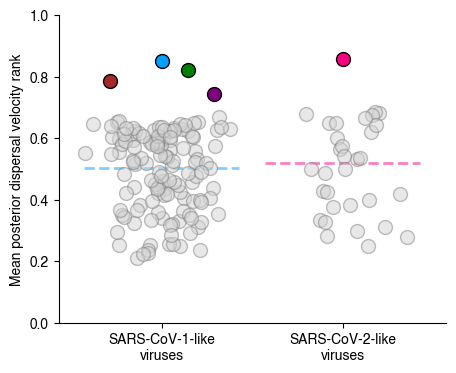

/var/folders/ls/3swb_7515hv8jb0mjxshss480000gp/T/ipykernel_12530/3255886740.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(x) for x in major_yticks], minor=False)


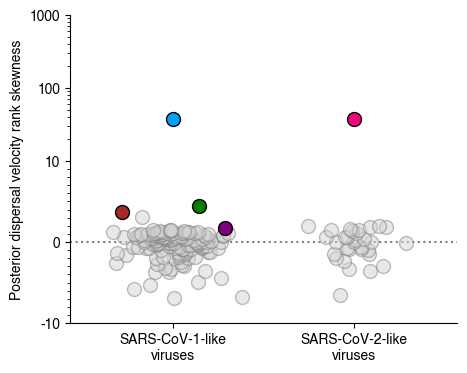

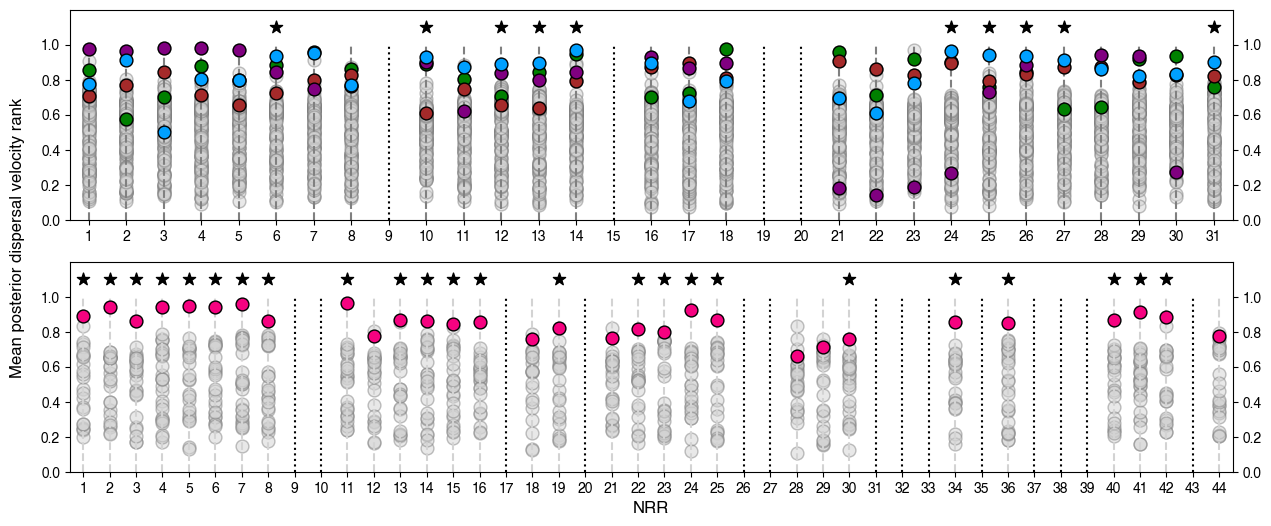

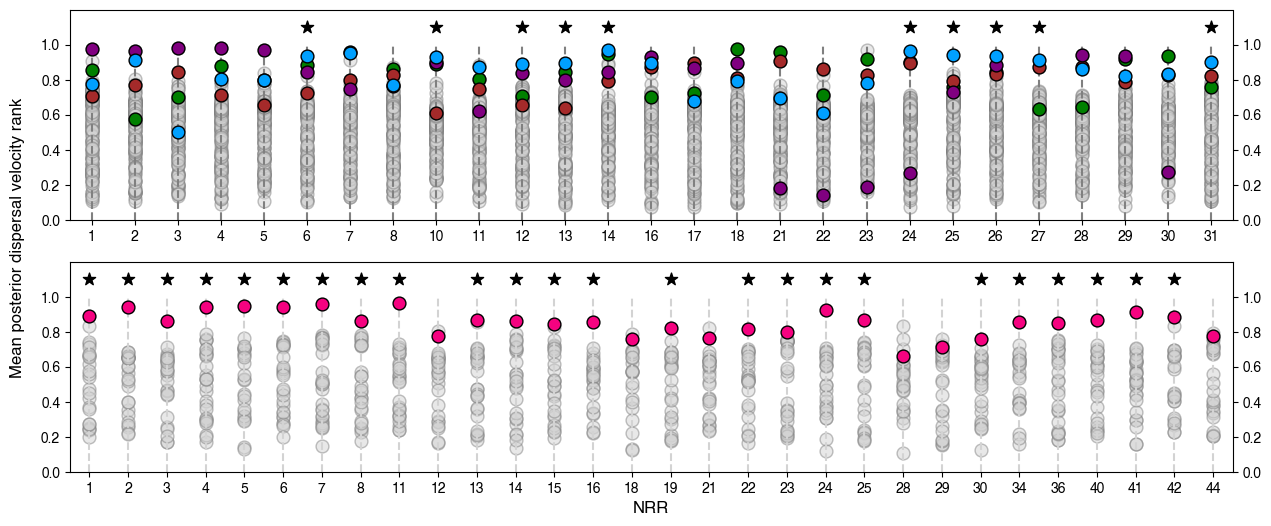

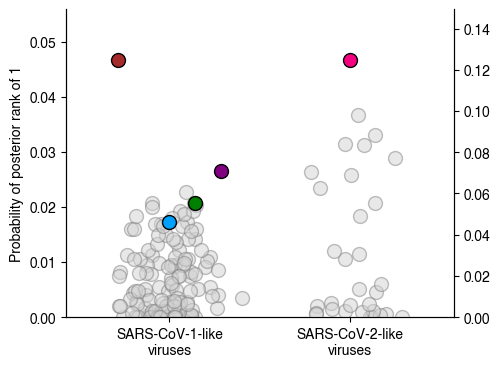

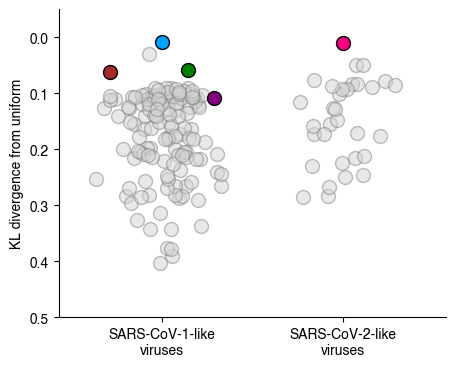

In [6]:
text_plots(sc1_ghosts_results_df, sc2_late2020_ghosts_results_df, ghost=True, outdir='../figures/', prefix='sc1_vs_sc2_late2020_ghosts')

# 7. Comparison of SC dispersal velocities with and without ghost 

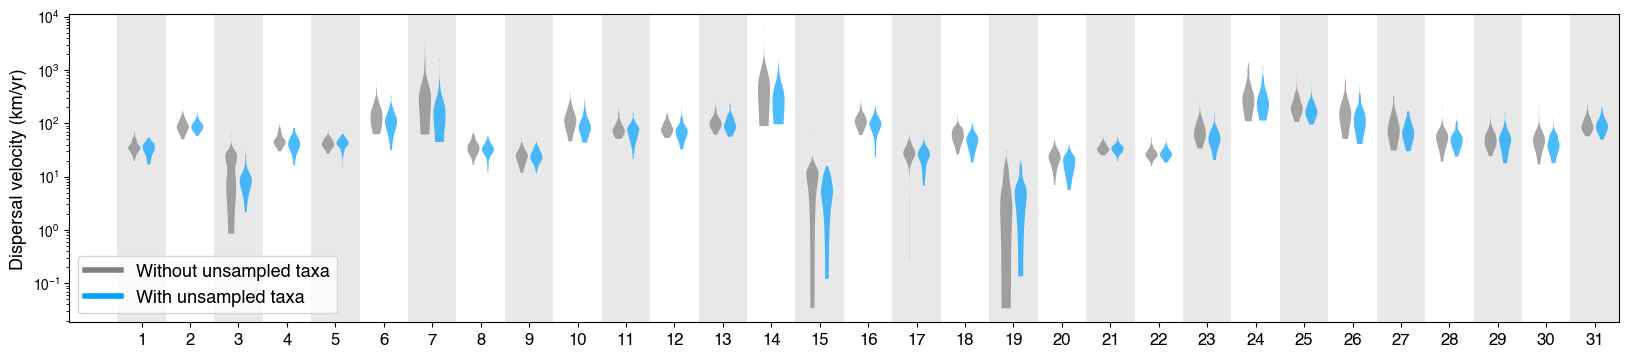

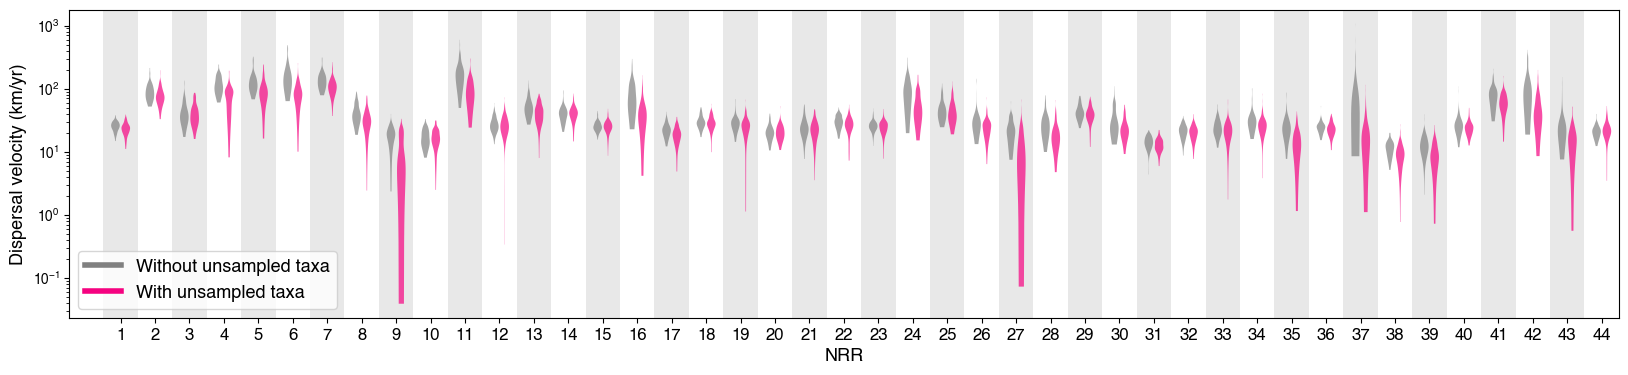

In [7]:
def plot_dispersal_velocity_comparison(results_df, ghosts_results_df, sc, xlabel=None):
    if sc == 1:
        sc_color = '#00a0ff'
        # Filter data for SC1_AY394995.1 and ghostMRCAparent_to_SC1_AY394995.1
        sc_data = results_df[results_df['tipLabel'] == 'SC1_AY394995.1'].copy()
        ghost_data = ghosts_results_df[ghosts_results_df['tipLabel'] == 'ghostMRCAparent_to_SC1_AY394995.1'].copy()
    elif sc == 2:
        sc_color = '#f50280'
        # Filter data for SC2_MN908947.3 and ghostMRCAparent_to_SC2_MN908947.3
        sc_data = results_df[results_df['tipLabel'] == 'SC2_MN908947.3'].copy()
        ghost_data = ghosts_results_df[ghosts_results_df['tipLabel'] == 'ghostMRCAparent_to_SC2_MN908947.3'].copy()

    # Add a 'dataset' column to differentiate the datasets
    sc_data['dataset'] = 'Without unsampled taxa'
    ghost_data['dataset'] = 'With unsampled taxa'

    # Combine both datasets into one
    combined_data = pd.concat([sc_data, ghost_data])

    # Create a new figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))

    # Use violinplot with hue='dataset' to separate violins
    sns.violinplot(x='NRR', y='dispersal_velocity', data=combined_data, cut=0, hue='dataset', ax=ax, inner=None, linewidth=0, palette=['grey', sc_color], dodge=True, zorder=100)

    # make y-axis log scale
    plt.yscale('log')

    # Add thick light grey bars for every other NRR
    nrr_values = sorted(combined_data['NRR'].unique())
    for i, nrr in enumerate(nrr_values):
        if i % 2 == 0:
            ax.axvspan(nrr-0.5, nrr+0.5, facecolor='lightgrey', alpha=0.5, zorder=0)

    # custom legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[:], labels=['Without unsampled taxa', 'With unsampled taxa'], loc='lower left', title=None, fontsize=13)

    # xlim
    ax.set_xlim([-0.5, max(nrr_values)-0.5])

    # make xticks larger
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

    # Optionally set axis labels and title
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel('Dispersal velocity (km/yr)', fontsize=13)

    # save
    plt.show()
    plt.close()
    

def plot_dispersal_velocity_comparison(results_df, ghosts_results_df, sc, xlabel=None):
    # Define color based on the `sc` parameter
    sc_color = '#00a0ff' if sc == 1 else '#f50280'
    tip_label_sc = 'SC1_AY394995.1' if sc == 1 else 'SC2_MN908947.3'
    tip_label_ghost = 'ghostMRCAparent_to_SC1_AY394995.1' if sc == 1 else 'ghostMRCAparent_to_SC2_MN908947.3'

    # Filter data based on specified tip labels
    sc_data = results_df[results_df['tipLabel'] == tip_label_sc].copy()
    ghost_data = ghosts_results_df[ghosts_results_df['tipLabel'] == tip_label_ghost].copy()

    # Combine datasets with a new column to distinguish them
    sc_data['dataset'] = 'Without unsampled taxa'
    ghost_data['dataset'] = 'With unsampled taxa'
    combined_data = pd.concat([sc_data, ghost_data])

    # Create a figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))

    # Sort unique NRR values and define offset for the violin plots
    nrr_values = sorted(combined_data['NRR'].unique())
    offset = 0.15

    # Plot violin plots for each NRR and dataset
    for i, nrr in enumerate(nrr_values):
        # Select dispersal velocities for the specific NRR in each dataset
        sc_data_nrr = sc_data[sc_data['NRR'] == nrr]['dispersal_velocity']
        ghost_data_nrr = ghost_data[ghost_data['NRR'] == nrr]['dispersal_velocity']
        
        # Plot SC data (without unsampled taxa) at `nrr - offset`
        vp1 = ax.violinplot(sc_data_nrr, positions=[nrr - offset], widths=0.25, showmeans=False, showmedians=False)
        vp1['bodies'][0].set_facecolor('grey')
        vp1['bodies'][0].set_alpha(0.7)
        
        # Remove max-min lines for SC data
        for part in ('cbars', 'cmins', 'cmaxes'):
            vp1[part].set_visible(False)

        # Plot Ghost data (with unsampled taxa) at `nrr + offset`
        vp2 = ax.violinplot(ghost_data_nrr, positions=[nrr + offset], widths=0.25, showmeans=False, showmedians=False)
        vp2['bodies'][0].set_facecolor(sc_color)
        vp2['bodies'][0].set_alpha(0.7)
        
        # Remove max-min lines for Ghost data
        for part in ('cbars', 'cmins', 'cmaxes'):
            vp2[part].set_visible(False)

        # Add background shading for every other NRR value
        if i % 2 == 0:
            ax.axvspan(nrr - 0.5, nrr + 0.5, facecolor='lightgrey', alpha=0.5, zorder=0)

    # Set y-axis to log scale and adjust x-axis limits
    ax.set_yscale('log')
    ax.set_xlim([-0.5, max(nrr_values) + 0.5])

    # Set x-axis labels and ticks
    ax.set_xticks(nrr_values)
    ax.set_xticklabels(nrr_values, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel('Dispersal velocity (km/yr)', fontsize=13)

    # Custom legend to distinguish datasets
    custom_legend = [plt.Line2D([0], [0], color='grey', lw=4, label='Without unsampled taxa'),
                     plt.Line2D([0], [0], color=sc_color, lw=4, label='With unsampled taxa')]
    ax.legend(handles=custom_legend, loc='lower left', fontsize=13)

    # Show and close plot
    plt.show()
    plt.close()


plot_dispersal_velocity_comparison(sc1_results_df, sc1_ghosts_results_df, sc=1)
plot_dispersal_velocity_comparison(sc2_late2020_results_df, sc2_late2020_ghosts_results_df, sc=2, xlabel='NRR')